In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [46]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahmasleam/intel-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-dataset


In [47]:
import os

def count_folders_and_images(dataset_path):
    total_folders = 0
    total_images = 0
    for root, dirs, files in os.walk(dataset_path):
        total_folders += len(dirs)  # Count all directories
        total_images += len([file for file in files if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))])

    return total_folders, total_images


In [48]:

# Replace `path` with the actual path to your downloaded dataset folder
dataset_path = "/kaggle/input/intel-image-dataset/Intel Image Dataset"
num_folders, num_images = count_folders_and_images(dataset_path)

print(f"Number of folders (including subfolders): {num_folders}")
print(f"Number of images: {num_images}")


Number of folders (including subfolders): 6
Number of images: 3000


In [49]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
data_dir = "/kaggle/input/intel-image-dataset/Intel Image Dataset" 
output_dir = 'split_dataset' 
train_ratio = 0.8  

# Create output directories for train and test
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each category (subfolder) in the dataset
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

for category in categories:
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)

    # Split the dataset into train and test
    train_images, test_images = train_test_split(images, train_size=train_ratio, random_state=42)

    # Create category subfolders in train and test directories
    train_category_dir = os.path.join(train_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    # Move images to respective directories
    for image in train_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(train_category_dir, image))

    for image in test_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(test_category_dir, image))

print(f"Dataset split complete!\nTrain directory: {train_dir}\nTest directory: {test_dir}")


Dataset split complete!
Train directory: split_dataset/train
Test directory: split_dataset/test


Random Train Images:
Showing random images from category: mountain


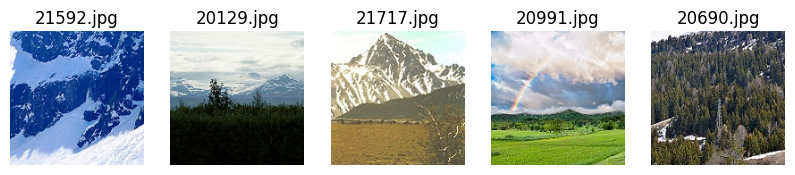

Random Test Images:
Showing random images from category: sea


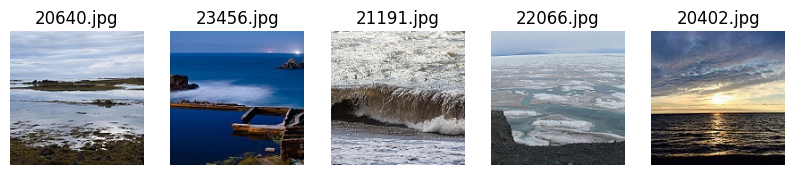

In [50]:
import os
import random
from matplotlib import pyplot as plt
from PIL import Image

directory = "/kaggle/input/intel-image-dataset/Intel Image Dataset" 

def show_random_images(directory, num_images=5):
    """
    Display random images from a directory.
    
    Args:
        directory (str): Path to the directory containing category subfolders.
        num_images (int): Number of random images to display.
    """
    # Get all category subfolders
    categories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    if not categories:
        print(f"No categories found in {directory}")
        return

    # Select random category and images
    category = random.choice(categories)
    category_path = os.path.join(directory, category)
    images = os.listdir(category_path)
    if not images:
        print(f"No images found in category {category} of {directory}")
        return

    random_images = random.sample(images, min(len(images), num_images))

    # Display images
    print(f"Showing random images from category: {category}")
    plt.figure(figsize=(10, 5))
    for i, image_name in enumerate(random_images, start=1):
        image_path = os.path.join(category_path, image_name)
        image = Image.open(image_path)
        plt.subplot(1, len(random_images), i)
        plt.imshow(image)
        plt.axis('off')
        plt.title(image_name)
    plt.show()

# Display random images from train and test directories
print("Random Train Images:")
show_random_images('split_dataset/train')

print("Random Test Images:")
show_random_images('split_dataset/test')


In [51]:
import sys
from matplotlib import pyplot as plt
import tensorflow
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score, roc_curve, auc
import seaborn as sns

In [52]:
from tensorflow.keras.applications import ResNet50

# Define the model using ResNet50
def define_model(num_classes):
    # Load the pre-trained ResNet50 model without the top classifier layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

    # Build the model
    model = Sequential()
    model.add(base_model)

    # Add custom classification head
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [53]:
num_classes = 6  
model = define_model(num_classes)

In [54]:
def plot_curves(history):
    # Plot Accuracy Curves
    plt.figure(figsize=(12, 4))

    # Training vs Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training vs Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [40]:
def plot_pr_curve(y_true, y_probs, num_classes):
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot_curves(history):
    # Plot Accuracy Curves
    plt.figure(figsize=(12, 4))

    # Training vs Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training vs Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [56]:

def plot_pr_curve(y_true, y_probs, num_classes):
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()


In [57]:

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [17]:
# Main function to run the training and evaluation
def run_test_harness():
    # Prepare data generators
    datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    # Train and test directories
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        train_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',  # Multi-class classification
        shuffle=True
    )

    test_it = datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=False
    )

    # Define the model
    num_classes = len(train_it.class_indices)  # Number of classes
    model = define_model(num_classes)

    # Train the model
    print("Training the model...")
    history = model.fit(
        train_it,
        validation_data=test_it,
        epochs=20
    )

    # Plot accuracy and loss curves for comparison
    plot_curves(history)

    # Evaluate the model on test data
    print("Evaluating the model...")
    test_steps = len(test_it)
    y_probs = model.predict(test_it, steps=test_steps, verbose=1)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = test_it.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Plot Confusion Matrix
    class_names = list(test_it.class_indices.keys())
    plot_confusion_matrix(cm, class_names)

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", report)

    # One-hot encode y_true
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1

    # Precision-Recall Curves
    plot_pr_curve(y_true_one_hot, y_probs, num_classes)

    # Save Confusion Matrix to CSV
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm_df.to_csv('confusion_matrix.csv', index=True)

    # Save Classification Report
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv('classification_report.csv', index=True)

    print("Model training and evaluation complete.")


Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Training the model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.2591 - loss: 1.9673 - val_accuracy: 0.4252 - val_loss: 1.3500
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.4566 - loss: 1.2923 - val_accuracy: 0.5365 - val_loss: 1.1768
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.5802 - loss: 1.1480 - val_accuracy: 0.4900 - val_loss: 1.1650
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.5665 - loss: 1.0679 - val_accuracy: 0.5415 - val_loss: 1.1128
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.6062 - loss: 1.0100 - val_accuracy: 0.5332 - val_loss: 1.1004
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.6022 - loss: 1.0012 - val_accuracy: 0.5415 - val_loss: 1.0922
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.6310 - loss: 0.9344 - val_accuracy: 0.5615 - val_loss: 1.0338
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.6752 - loss: 0.8605 - val_accuracy: 0.5648 - val_los

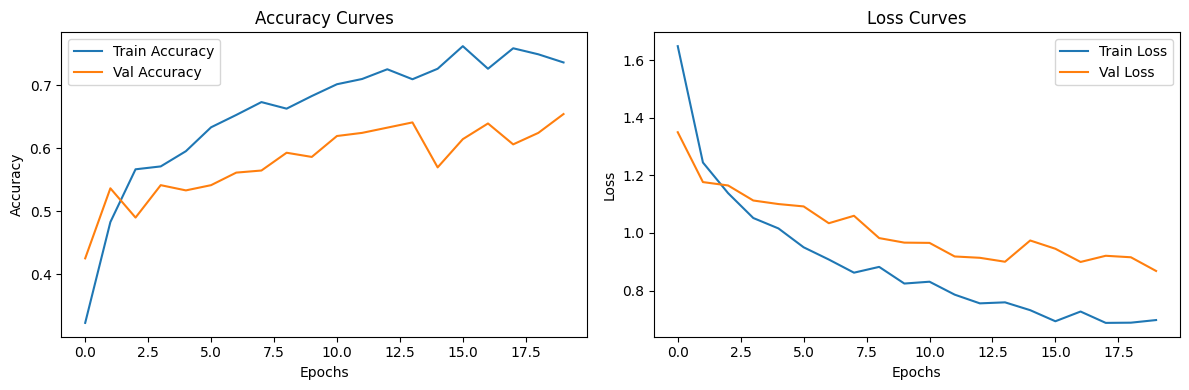

Evaluating the model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step
Confusion Matrix:
 [[42  7  4  2  5 28]
 [ 1 81  2  1  3  7]
 [ 2  0 72 23 13  1]
 [ 1  1 22 62 18  1]
 [ 3  0 17 22 58  2]
 [ 4  9  3  2  4 79]]


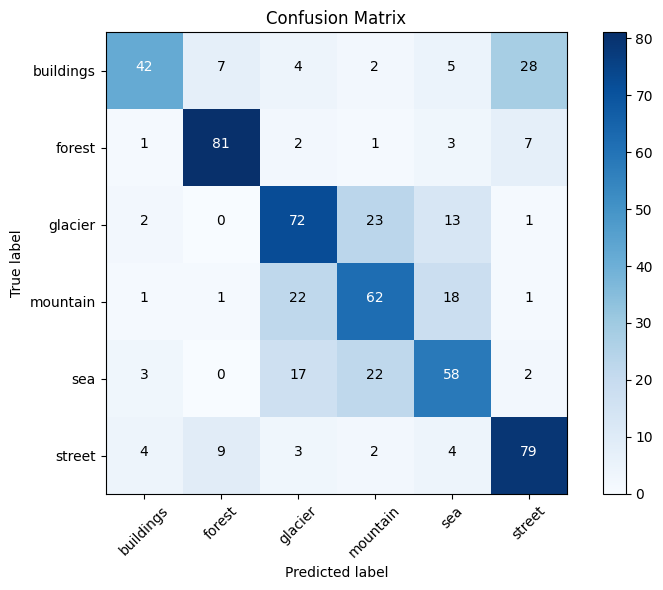

Classification Report:
               precision    recall  f1-score   support

   buildings       0.79      0.48      0.60        88
      forest       0.83      0.85      0.84        95
     glacier       0.60      0.65      0.62       111
    mountain       0.55      0.59      0.57       105
         sea       0.57      0.57      0.57       102
      street       0.67      0.78      0.72       101

    accuracy                           0.65       602
   macro avg       0.67      0.65      0.65       602
weighted avg       0.66      0.65      0.65       602



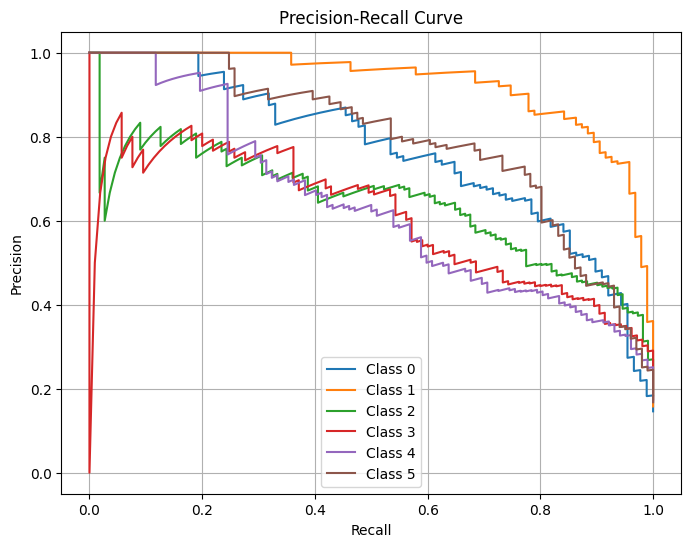

Model training and evaluation complete.


In [18]:
run_test_harness()

In [19]:
# Main function to run the training and evaluation
def run_test_harness():
    # Prepare data generators
    datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    # Train and test directories
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        train_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',  # Multi-class classification
        shuffle=True
    )

    test_it = datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=False
    )

    # Define the model
    num_classes = len(train_it.class_indices)  # Number of classes
    model = define_model(num_classes)

    # Train the model
    print("Training the model...")
    history = model.fit(
        train_it,
        validation_data=test_it,
        epochs=50
    )

    # Plot accuracy and loss curves for comparison
    plot_curves(history)

    # Evaluate the model on test data
    print("Evaluating the model...")
    test_steps = len(test_it)
    y_probs = model.predict(test_it, steps=test_steps, verbose=1)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = test_it.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Plot Confusion Matrix
    class_names = list(test_it.class_indices.keys())
    plot_confusion_matrix(cm, class_names)

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", report)

    # One-hot encode y_true
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1

    # Precision-Recall Curves
    plot_pr_curve(y_true_one_hot, y_probs, num_classes)

    # Save Confusion Matrix to CSV
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm_df.to_csv('confusion_matrix.csv', index=True)

    # Save Classification Report
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv('classification_report.csv', index=True)

    print("Model training and evaluation complete.")


Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Training the model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.2570 - loss: 2.0046 - val_accuracy: 0.4352 - val_loss: 1.3644
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.4740 - loss: 1.2949 - val_accuracy: 0.4817 - val_loss: 1.2228
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.5292 - loss: 1.1771 - val_accuracy: 0.5548 - val_loss: 1.1282
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.6024 - loss: 1.0306 - val_accuracy: 0.5150 - val_loss: 1.1874
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.6269 - loss: 0.9849 - val_accuracy: 0.5897 - val_loss: 1.0073
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.6266 - loss: 0.9497 - val_accuracy: 0.5581 - val_loss: 1.0583
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.6524 - loss: 0.9348 - val_accuracy: 0.5963 - val_loss: 0.9770
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.6829 - loss: 0.8420 - val_accuracy: 0.6229 - val

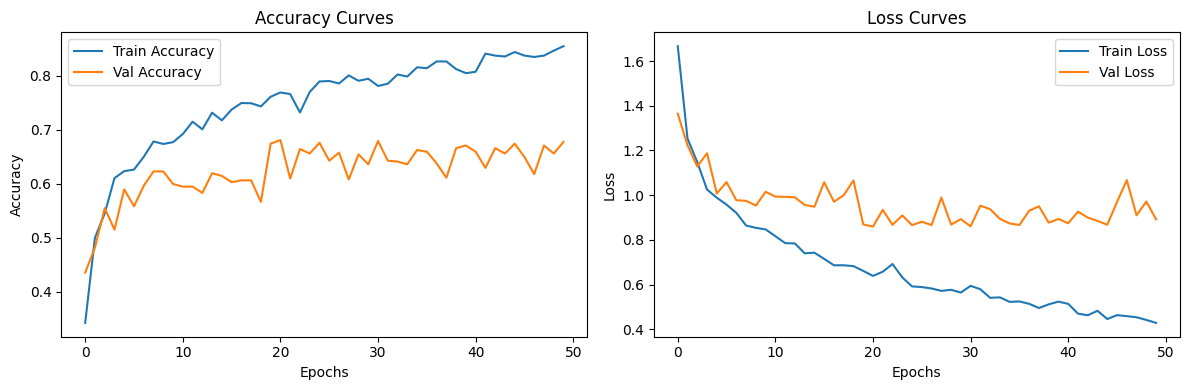

Evaluating the model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step
Confusion Matrix:
 [[68  3  3  1  1 12]
 [ 6 78  4  0  3  4]
 [ 3  0 81 21  6  0]
 [ 3  0 24 68  8  2]
 [ 6  1 21 22 51  1]
 [27  5  3  2  2 62]]


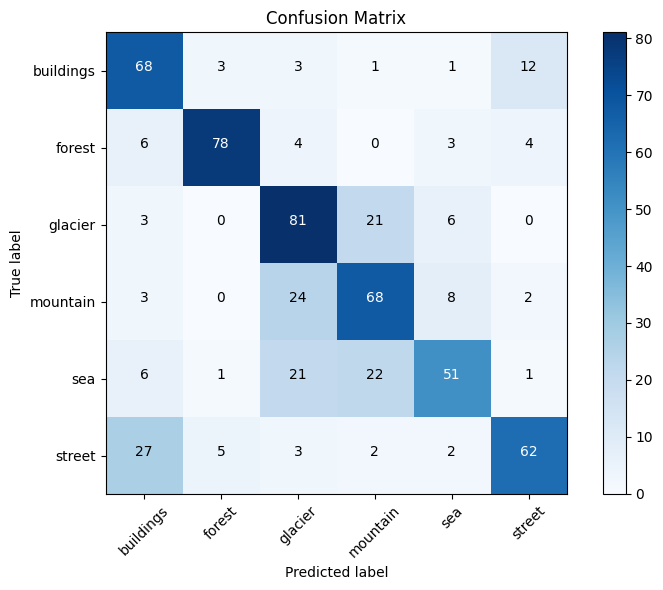

Classification Report:
               precision    recall  f1-score   support

   buildings       0.60      0.77      0.68        88
      forest       0.90      0.82      0.86        95
     glacier       0.60      0.73      0.66       111
    mountain       0.60      0.65      0.62       105
         sea       0.72      0.50      0.59       102
      street       0.77      0.61      0.68       101

    accuracy                           0.68       602
   macro avg       0.70      0.68      0.68       602
weighted avg       0.69      0.68      0.68       602



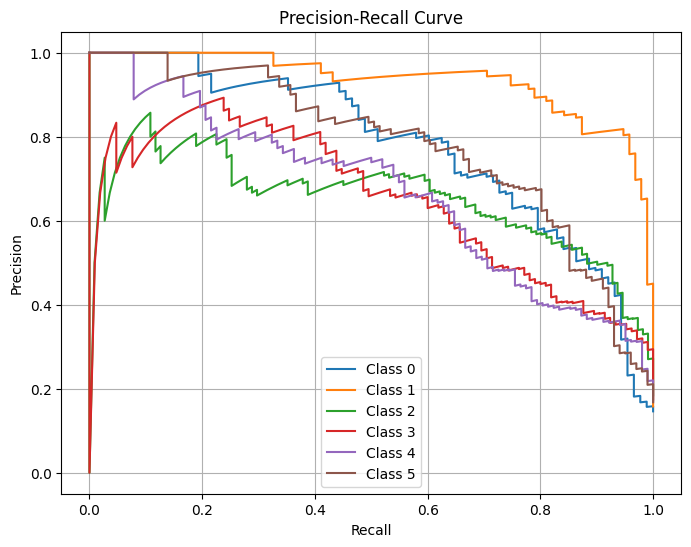

Model training and evaluation complete.


In [20]:
run_test_harness()

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model using ResNet50, with an option to freeze half the layers
def define_model(num_classes, freeze_half=True):
    # Load the pre-trained ResNet50 model without the top classifier layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Determine how many layers to freeze
    total_layers = len(base_model.layers)
    layers_to_freeze = total_layers // 2 if freeze_half else total_layers

    # Freeze the specified number of layers
    for i, layer in enumerate(base_model.layers):
        if i < layers_to_freeze:
            layer.trainable = False
        else:
            layer.trainable = True

    # Build the model
    model = Sequential()
    model.add(base_model)

    # Add custom classification head
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform')) 
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Training the model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 418ms/step - accuracy: 0.3770 - loss: 2.4077 - val_accuracy: 0.2193 - val_loss: 2.1749
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.6711 - loss: 0.8473 - val_accuracy: 0.2475 - val_loss: 2.0590
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.7124 - loss: 0.7797 - val_accuracy: 0.4053 - val_loss: 1.5051
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - accuracy: 0.7545 - loss: 0.6052 - val_accuracy: 0.4419 - val_loss: 1.9863
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.8175 - loss: 0.5140 - val_accuracy: 0.6944 - val_loss: 0.8673
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.8463 - loss: 0.4242 - val_accuracy: 0.6993 - val_loss: 0.9742
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.8686 - loss: 0.3568 - val_accuracy: 0.6628 - val_loss: 1.1002
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - accuracy: 0.8885 - loss: 0.3216 - val_accuracy: 0.644

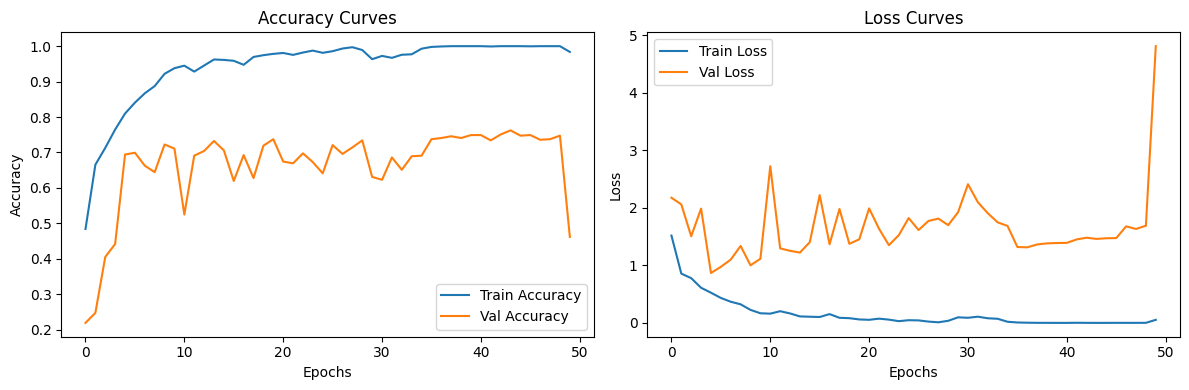

Evaluating the model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step
Confusion Matrix:
 [[50 15  0  0  1 22]
 [ 0 94  0  0  0  1]
 [ 8 31 30  1  9 32]
 [16 45 11  6 15 12]
 [ 4 51  0  1 33 13]
 [11 23  0  0  2 65]]


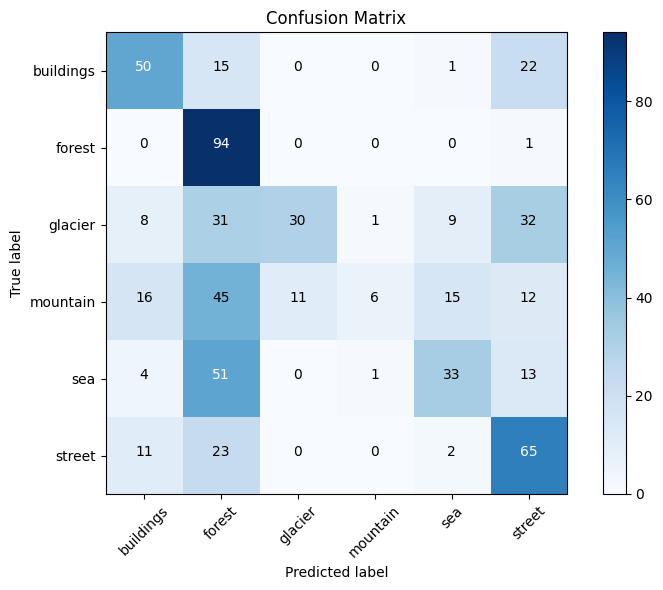

Classification Report:
               precision    recall  f1-score   support

   buildings       0.56      0.57      0.56        88
      forest       0.36      0.99      0.53        95
     glacier       0.73      0.27      0.39       111
    mountain       0.75      0.06      0.11       105
         sea       0.55      0.32      0.41       102
      street       0.45      0.64      0.53       101

    accuracy                           0.46       602
   macro avg       0.57      0.48      0.42       602
weighted avg       0.57      0.46      0.42       602



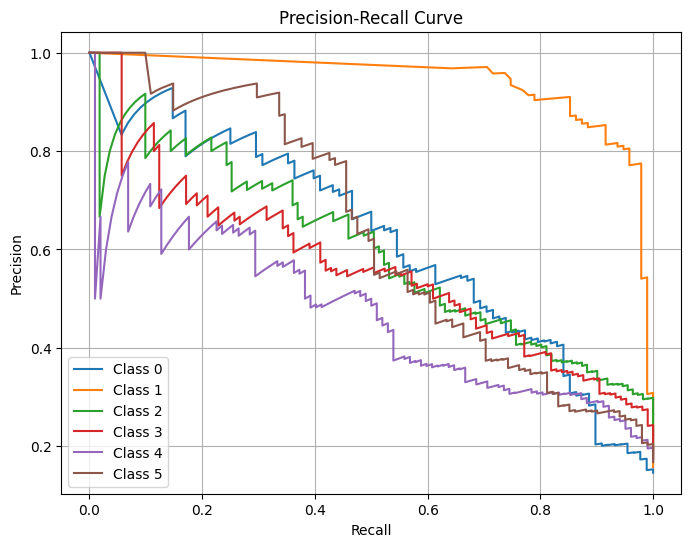

Model training and evaluation complete.


In [22]:
run_test_harness()

In [23]:
# Define the model using ResNet50, with an option to freeze half the layers
def define_model(num_classes, freeze_half=True):
    # Load the pre-trained ResNet50 model without the top classifier layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Determine how many layers to freeze
    total_layers = len(base_model.layers)
    layers_to_freeze = total_layers // 3 if freeze_half else total_layers

    # Freeze the specified number of layers
    for i, layer in enumerate(base_model.layers):
        if i < layers_to_freeze:
            layer.trainable = False
        else:
            layer.trainable = True

    # Build the model
    model = Sequential()
    model.add(base_model)

    # Add custom classification head
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform')) 
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Training the model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 467ms/step - accuracy: 0.4423 - loss: 2.1913 - val_accuracy: 0.1860 - val_loss: 1.8385
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.7617 - loss: 0.6314 - val_accuracy: 0.2608 - val_loss: 2.3670
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 231ms/step - accuracy: 0.8469 - loss: 0.4149 - val_accuracy: 0.4518 - val_loss: 1.9318
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.9092 - loss: 0.2391 - val_accuracy: 0.4834 - val_loss: 2.5332
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.9414 - loss: 0.1769 - val_accuracy: 0.5482 - val_loss: 2.0266
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 223ms/step - accuracy: 0.9552 - loss: 0.1275 - val_accuracy: 0.6047 - val_loss: 1.9924
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.9335 - loss: 0.1725 - val_accuracy: 0.6728 - val_loss: 1.2623
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.9685 - loss: 0.0936 - val_accuracy: 0.735

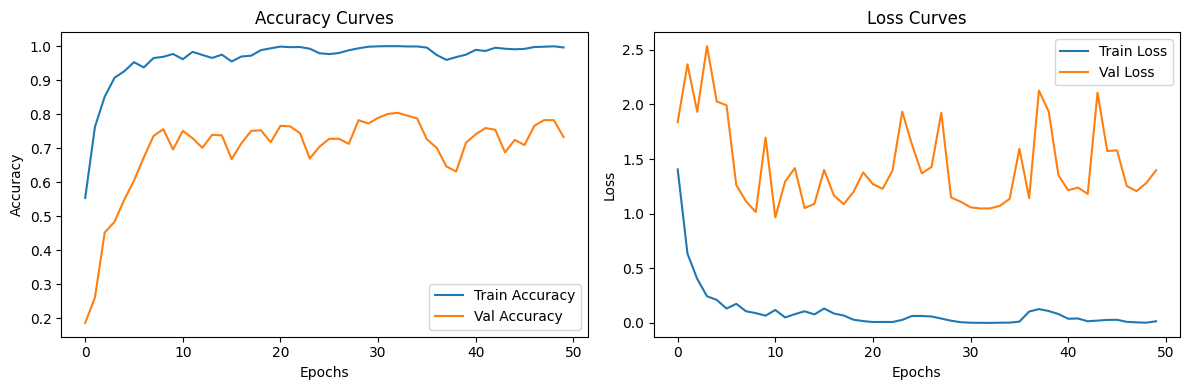

Evaluating the model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step
Confusion Matrix:
 [[59  1  6  0  3 19]
 [ 0 81  6  1  2  5]
 [ 0  0 99  3  9  0]
 [ 0  0 43 44 18  0]
 [ 0  0 22  2 78  0]
 [ 7  2  8  1  3 80]]


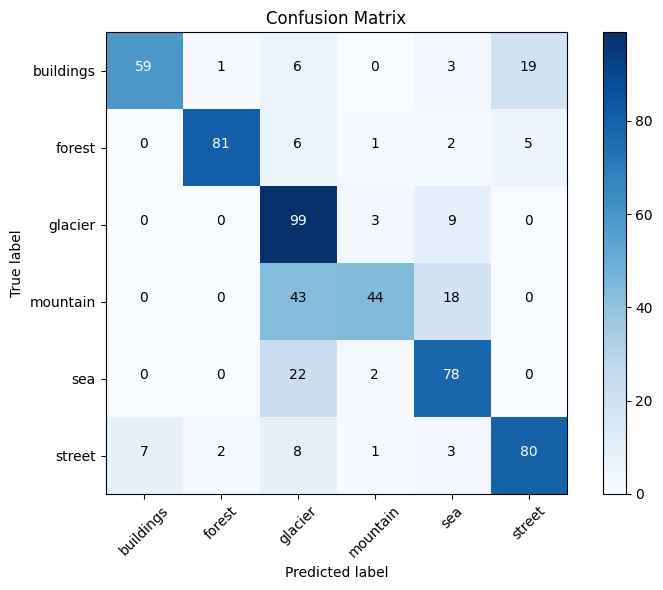

Classification Report:
               precision    recall  f1-score   support

   buildings       0.89      0.67      0.77        88
      forest       0.96      0.85      0.91        95
     glacier       0.54      0.89      0.67       111
    mountain       0.86      0.42      0.56       105
         sea       0.69      0.76      0.73       102
      street       0.77      0.79      0.78       101

    accuracy                           0.73       602
   macro avg       0.79      0.73      0.74       602
weighted avg       0.78      0.73      0.73       602



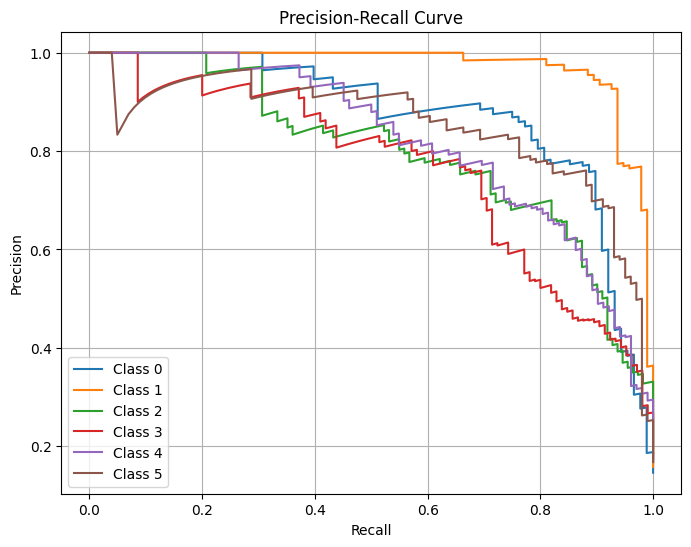

Model training and evaluation complete.


In [24]:
run_test_harness()

In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the model using ResNet50 with a configurable number of layers to unfreeze
def define_model(num_classes, unfreeze_layers=0):
    # Load the pre-trained ResNet50 model without the top classifier layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze all layers by default
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the specified number of layers
    for i in range(len(base_model.layers) - unfreeze_layers, len(base_model.layers)):
        base_model.layers[i].trainable = True

    # Build the model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_uniform'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Plot accuracy and loss curves
def plot_curves(history):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot Precision-Recall Curve
def plot_pr_curve(y_true, y_probs, num_classes):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        ap = average_precision_score(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f'Class {i} (AP: {ap:.2f})')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


# Function to train and evaluate the model with different unfreezing configurations
def run_experiment(train_dir, test_dir, num_classes, divisions):
    # Prepare data generators
    datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    train_it = datagen.flow_from_directory(train_dir, batch_size=32, target_size=(224, 224), class_mode='categorical', shuffle=True)
    test_it = datagen.flow_from_directory(test_dir, batch_size=32, target_size=(224, 224), class_mode='categorical', shuffle=False)

    total_layers = len(ResNet50(weights='imagenet').layers)
    layers_per_division = total_layers // divisions

    results = []
    for i in range(divisions + 1):
        unfreeze_layers = i * layers_per_division
        print(f"\nTraining with {unfreeze_layers} layers unfrozen...")

        # Define and train the model
        model = define_model(num_classes, unfreeze_layers)
        history = model.fit(train_it, validation_data=test_it, epochs=20, verbose=1)  # Use fewer epochs for quick evaluation

        # Evaluate the model
        test_steps = len(test_it)
        y_probs = model.predict(test_it, steps=test_steps, verbose=1)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = test_it.classes

        # Compute metrics
        accuracy = np.sum(y_pred == y_true) / len(y_true)
        results.append((unfreeze_layers, accuracy))
        print(f"Accuracy with {unfreeze_layers} unfrozen layers: {accuracy:.4f}")

        # Plot curves
        plot_curves(history)

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)
        class_names = list(test_it.class_indices.keys())
        plot_confusion_matrix(cm, class_names)

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=class_names)
        print("Classification Report:\n", report)

        # Precision-Recall Curves
        y_true_one_hot = np.zeros((len(y_true), num_classes))
        y_true_one_hot[np.arange(len(y_true)), y_true] = 1
        plot_pr_curve(y_true_one_hot, y_probs, num_classes)

    # Plot overall results
    unfreeze_counts, accuracies = zip(*results)
    plt.plot(unfreeze_counts, accuracies, marker='o')
    plt.title("Accuracy vs. Number of Unfrozen Layers")
    plt.xlabel("Number of Unfrozen Layers")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.show()

    return results

# Main function to execute the experiment
if __name__ == "__main__":
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'
    num_classes = 6  # Update based on the dataset
    divisions = 5    # Number of divisions for unfreezing layers

    results = run_experiment(train_dir, test_dir, num_classes, divisions)
    print("Experiment complete. Results:", results)






Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training with 0 layers unfrozen...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3046 - loss: 1.8231

KeyboardInterrupt: 

Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.

Training only the FC layer...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 543ms/step - accuracy: 0.5976 - loss: 1.2415 - val_accuracy: 0.8472 - val_loss: 0.4781
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.8790 - loss: 0.3948 - val_accuracy: 0.8920 - val_loss: 0.3151
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.8914 - loss: 0.3077 - val_accuracy: 0.9020 - val_loss: 0.2890
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9082 - loss: 0.2461 - val_accuracy: 0.9203 - val_loss: 0.2419
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.9152 - loss: 0.2355 - val_accuracy: 0.9186 - val_loss: 0.2306
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9183 - loss: 0.2234 - val_accuracy: 0.9186 - val_loss: 0.2256
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accura

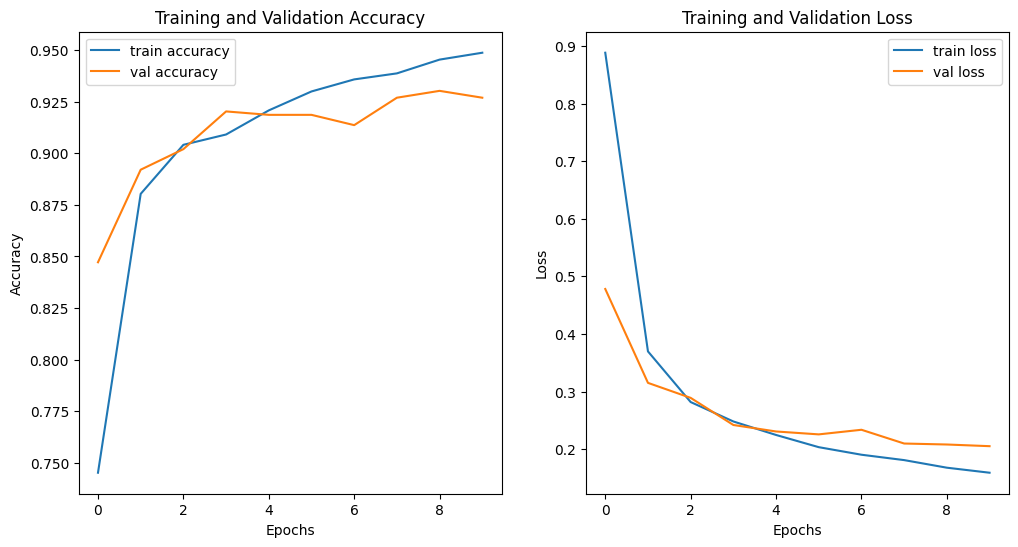

Confusion Matrix:
 [[ 79   0   0   0   0   9]
 [  0  94   0   1   0   0]
 [  0   0 104   6   1   0]
 [  0   0  18  87   0   0]
 [  0   0   2   1  99   0]
 [  4   0   1   1   0  95]]


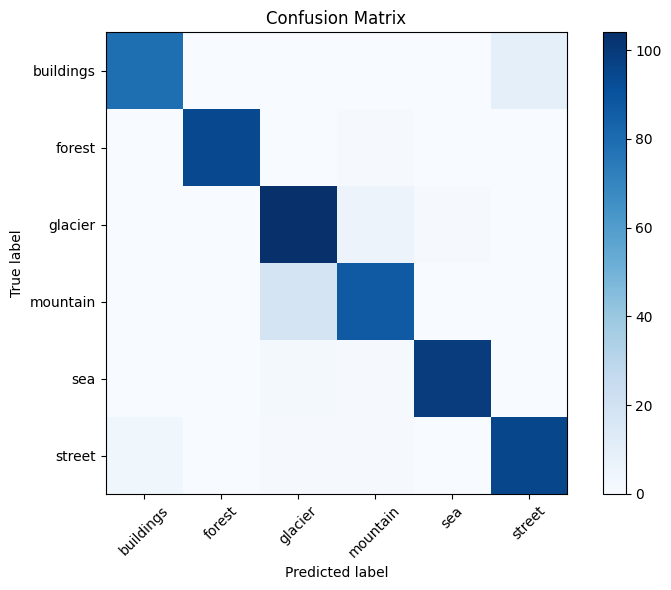

Classification Report:
               precision    recall  f1-score   support

   buildings       0.95      0.90      0.92        88
      forest       1.00      0.99      0.99        95
     glacier       0.83      0.94      0.88       111
    mountain       0.91      0.83      0.87       105
         sea       0.99      0.97      0.98       102
      street       0.91      0.94      0.93       101

    accuracy                           0.93       602
   macro avg       0.93      0.93      0.93       602
weighted avg       0.93      0.93      0.93       602


Proceeding to the main experiment with gradual unfreezing of layers...
Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Training with 0 layers unfrozen...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 321ms/step - accuracy: 0.5425 - loss: 1.2709 - val_accuracy: 0.8605 - val_loss: 0.4669
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.8742 - loss: 0.4132 - val_accuracy: 0.8887 - val_loss: 0.3220
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.8902 - loss: 0.3227 - val_accuracy: 0.9153 - val_loss: 0.2724
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9105 - loss: 0.2671 - val_accuracy: 0.9136 - val_loss: 0.2629
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9275 - loss: 0.2169 - val_accuracy: 0.9286 - val_loss: 0.2295
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9216 - loss: 0.2181 - val_accuracy: 0.9319 - val_loss: 0.2226
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9303 - loss: 0.2062 - val_accuracy: 0.9252 - val_loss: 0.2181
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9406 - loss: 0.1803 - val_accuracy: 0.928

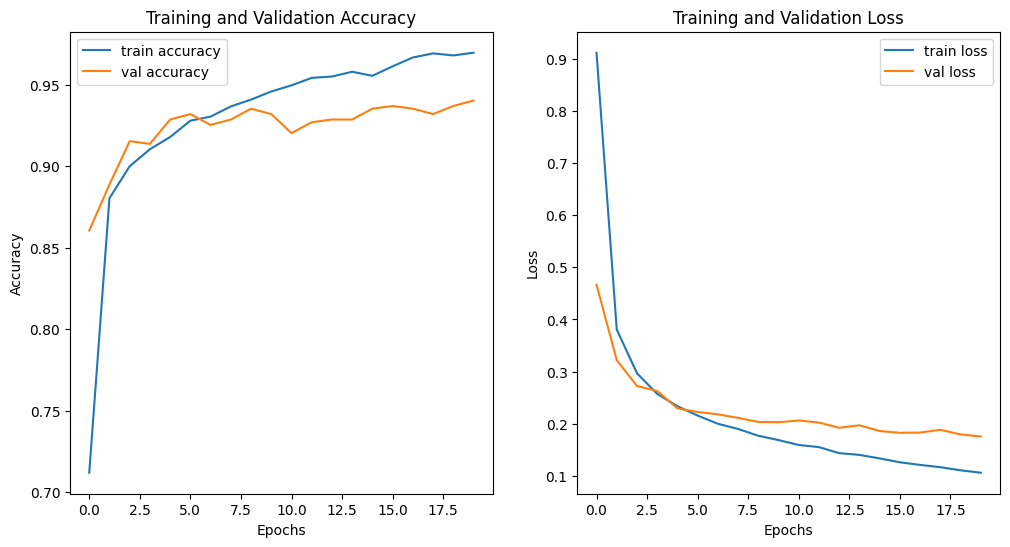

Confusion Matrix:
 [[ 83   0   0   0   0   5]
 [  0  94   0   1   0   0]
 [  0   0 103   8   0   0]
 [  0   0  13  92   0   0]
 [  0   0   1   0 101   0]
 [  7   0   0   1   0  93]]


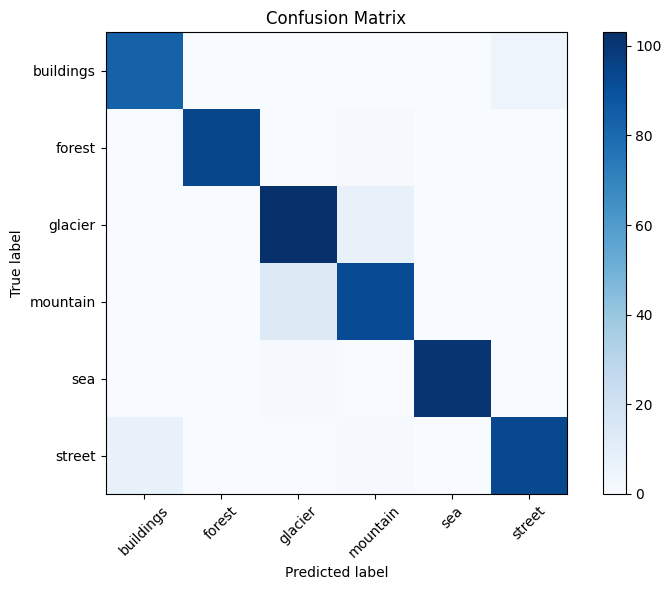

Classification Report:
               precision    recall  f1-score   support

   buildings       0.92      0.94      0.93        88
      forest       1.00      0.99      0.99        95
     glacier       0.88      0.93      0.90       111
    mountain       0.90      0.88      0.89       105
         sea       1.00      0.99      1.00       102
      street       0.95      0.92      0.93       101

    accuracy                           0.94       602
   macro avg       0.94      0.94      0.94       602
weighted avg       0.94      0.94      0.94       602



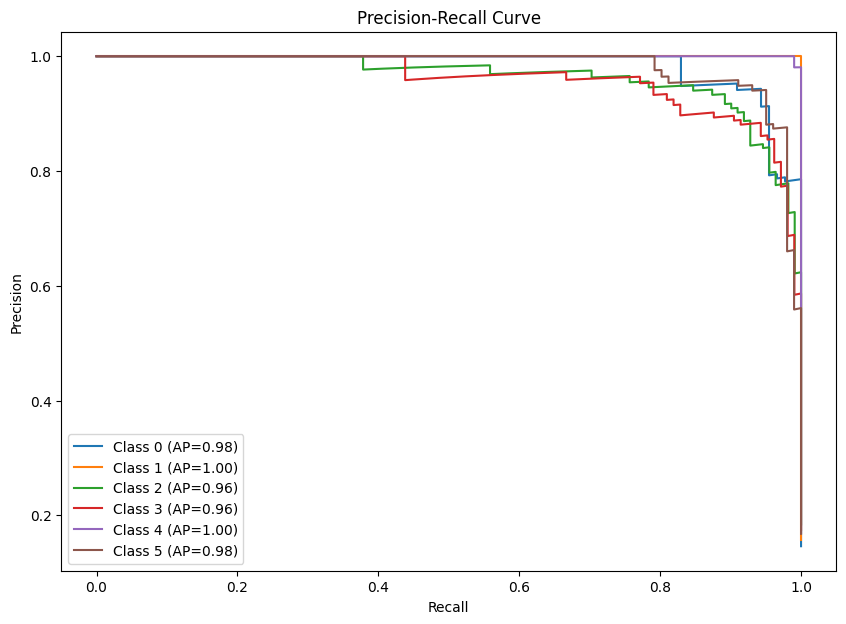


Training with 78 layers unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 490ms/step - accuracy: 0.7548 - loss: 0.7128 - val_accuracy: 0.9286 - val_loss: 0.1815
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.9612 - loss: 0.1282 - val_accuracy: 0.9319 - val_loss: 0.1860
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.9901 - loss: 0.0423 - val_accuracy: 0.9252 - val_loss: 0.1867
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.9933 - loss: 0.0216 - val_accuracy: 0.9369 - val_loss: 0.2029
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.9961 - loss: 0.0143 - val_accuracy: 0.9385 - val_loss: 0.2252
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.9993 - loss: 0.0056 - val_accuracy: 0.9385 - val_loss: 0.2269
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.9980 - loss: 0.0099 - val_accuracy: 0.9402 - val_loss: 0.2305
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accur

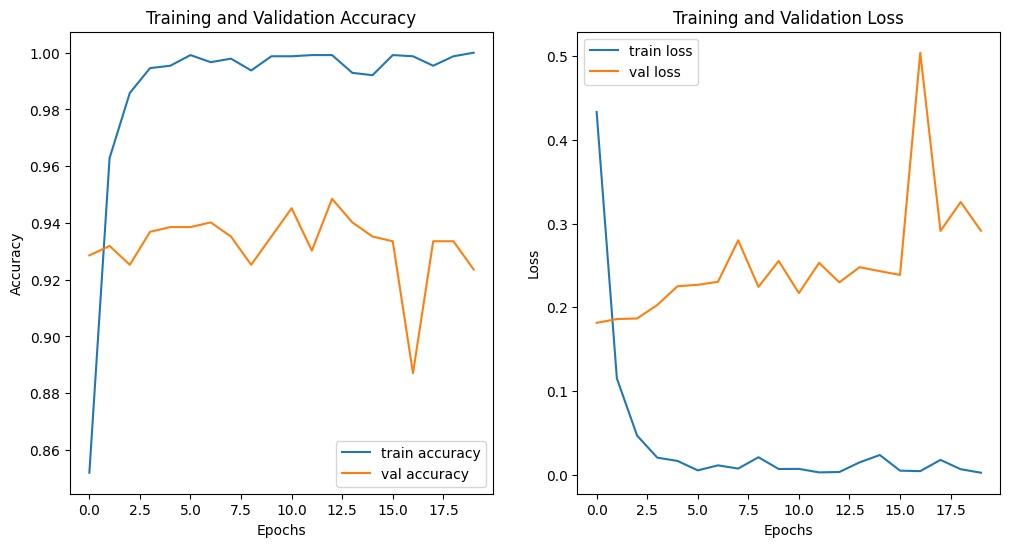

Confusion Matrix:
 [[ 75   0   0   0   0  13]
 [  0  94   0   1   0   0]
 [  0   0  99   9   3   0]
 [  0   0  12  91   2   0]
 [  1   0   0   0 101   0]
 [  5   0   0   0   0  96]]


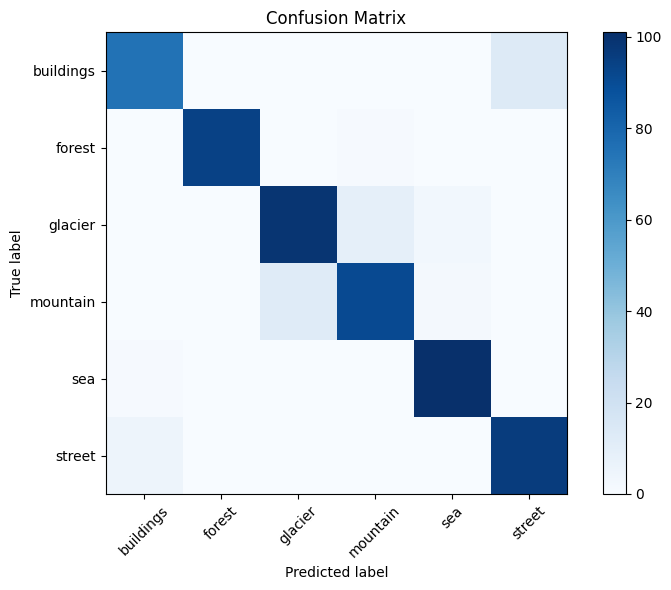

Classification Report:
               precision    recall  f1-score   support

   buildings       0.93      0.85      0.89        88
      forest       1.00      0.99      0.99        95
     glacier       0.89      0.89      0.89       111
    mountain       0.90      0.87      0.88       105
         sea       0.95      0.99      0.97       102
      street       0.88      0.95      0.91       101

    accuracy                           0.92       602
   macro avg       0.93      0.92      0.92       602
weighted avg       0.92      0.92      0.92       602



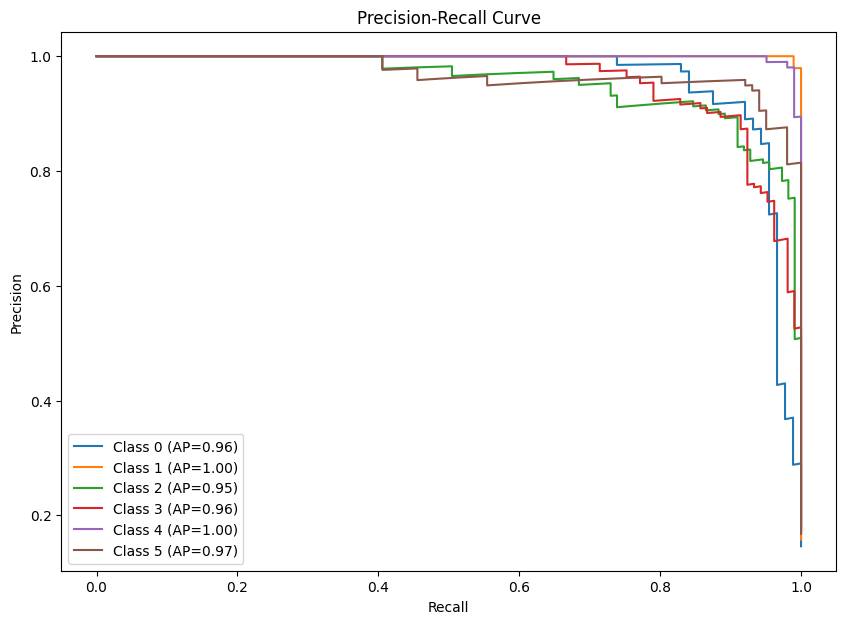


Training with 156 layers unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 608ms/step - accuracy: 0.7448 - loss: 0.7537 - val_accuracy: 0.9037 - val_loss: 0.2733
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.9747 - loss: 0.1001 - val_accuracy: 0.9169 - val_loss: 0.2326
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.9884 - loss: 0.0419 - val_accuracy: 0.9319 - val_loss: 0.2225
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.9930 - loss: 0.0270 - val_accuracy: 0.9136 - val_loss: 0.2615
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.9975 - loss: 0.0140 - val_accuracy: 0.9286 - val_loss: 0.3514
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 254ms/step - accuracy: 0.9916 - loss: 0.0183 - val_accuracy: 0.9153 - val_loss: 0.2903
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.9955 - loss: 0.0132 - val_accuracy: 0.9203 - val_loss: 0.2837
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accu

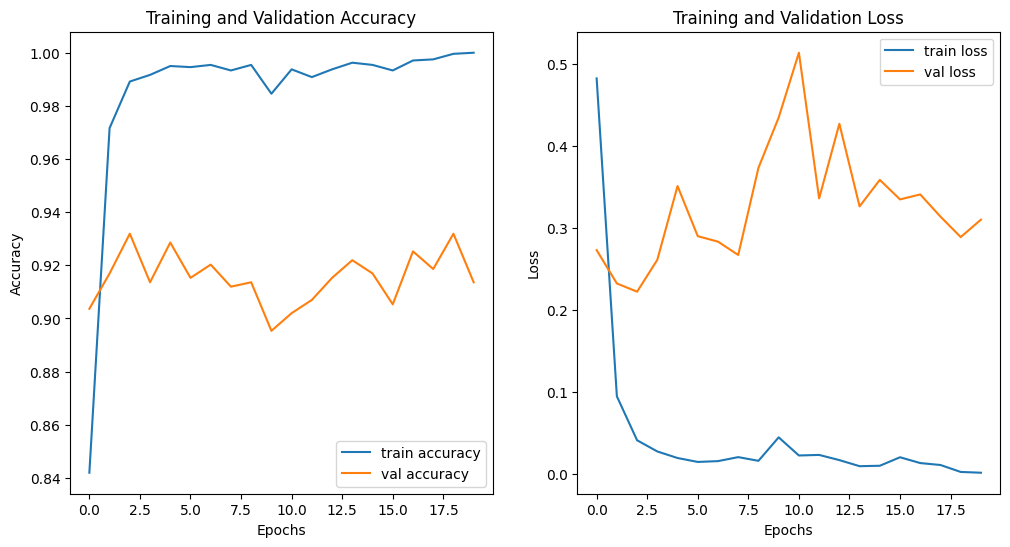

Confusion Matrix:
 [[78  0  0  0  0 10]
 [ 0 94  0  1  0  0]
 [ 0  1 97 12  1  0]
 [ 0  0 10 90  5  0]
 [ 2  0  1  2 97  0]
 [ 4  0  0  2  1 94]]


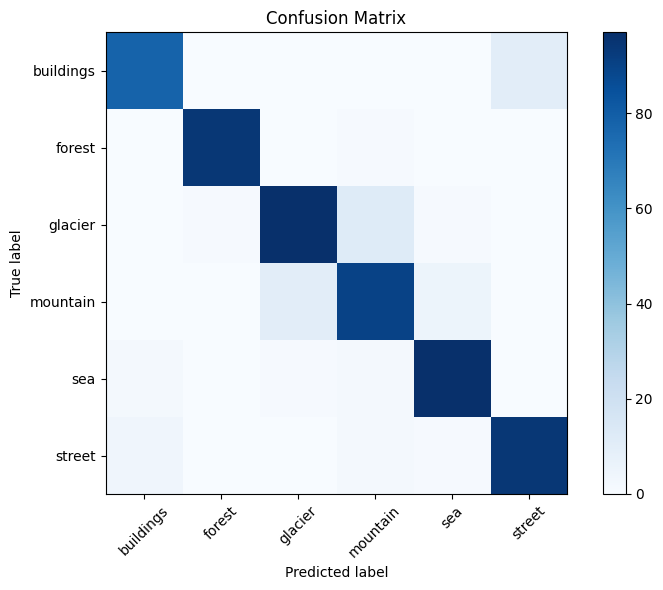

Classification Report:
               precision    recall  f1-score   support

   buildings       0.93      0.89      0.91        88
      forest       0.99      0.99      0.99        95
     glacier       0.90      0.87      0.89       111
    mountain       0.84      0.86      0.85       105
         sea       0.93      0.95      0.94       102
      street       0.90      0.93      0.92       101

    accuracy                           0.91       602
   macro avg       0.92      0.91      0.92       602
weighted avg       0.91      0.91      0.91       602



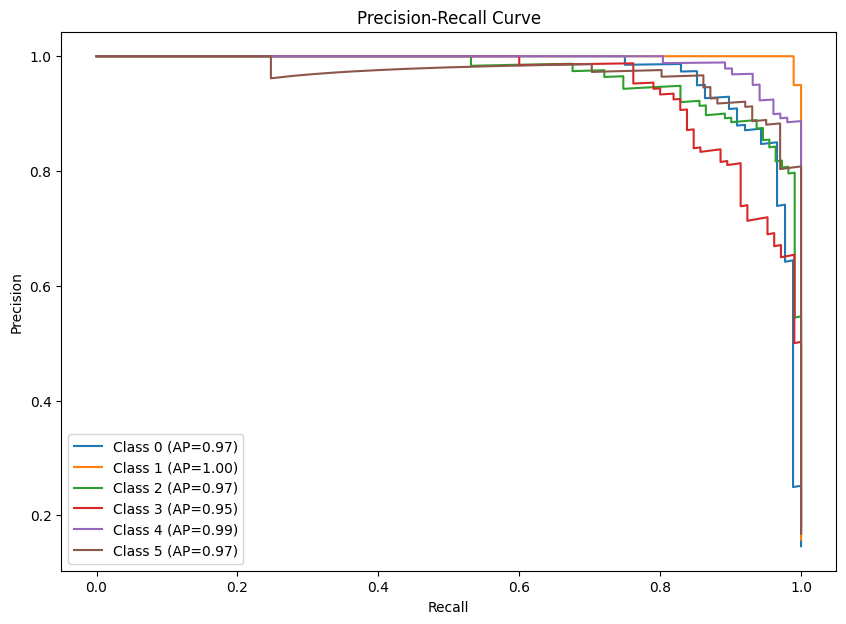


Training with 234 layers unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 110s 782ms/step - accuracy: 0.7239 - loss: 0.7601 - val_accuracy: 0.9053 - val_loss: 0.2623
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 327ms/step - accuracy: 0.9707 - loss: 0.1025 - val_accuracy: 0.9136 - val_loss: 0.2982
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 319ms/step - accuracy: 0.9869 - loss: 0.0378 - val_accuracy: 0.9136 - val_loss: 0.2935
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 317ms/step - accuracy: 0.9875 - loss: 0.0533 - val_accuracy: 0.8870 - val_loss: 0.3449
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - accuracy: 0.9980 - loss: 0.0146 - val_accuracy: 0.9120 - val_loss: 0.3397
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 321ms/step - accuracy: 0.9929 - loss: 0.0214 - val_accuracy: 0.8738 - val_loss: 0.4562
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 317ms/step - accuracy: 0.9925 - loss: 0.0206 - val_accuracy: 0.8688 - val_loss: 0.5197
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 319ms/step - acc

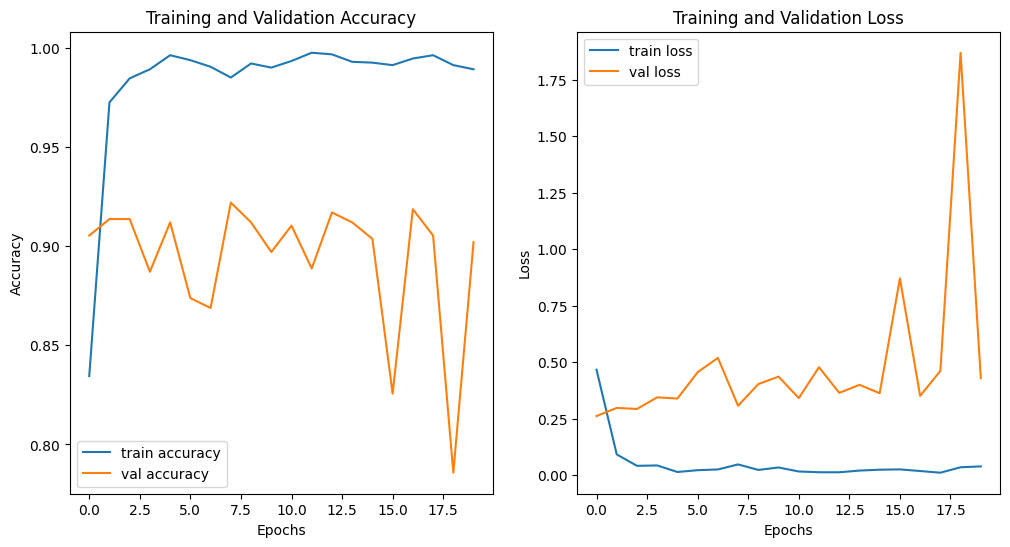

Confusion Matrix:
 [[82  0  0  0  0  6]
 [ 0 90  0  5  0  0]
 [ 0  0 87 21  3  0]
 [ 0  0  6 97  2  0]
 [ 0  0  0  7 95  0]
 [ 7  0  0  2  0 92]]


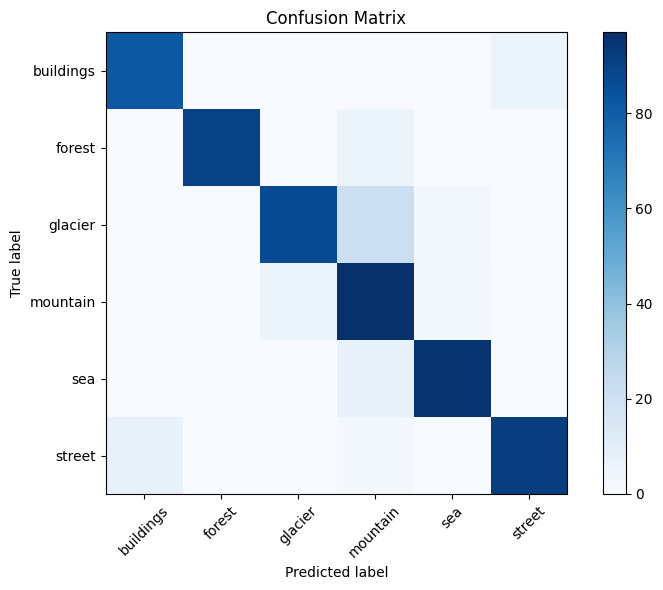

Classification Report:
               precision    recall  f1-score   support

   buildings       0.92      0.93      0.93        88
      forest       1.00      0.95      0.97        95
     glacier       0.94      0.78      0.85       111
    mountain       0.73      0.92      0.82       105
         sea       0.95      0.93      0.94       102
      street       0.94      0.91      0.92       101

    accuracy                           0.90       602
   macro avg       0.91      0.90      0.91       602
weighted avg       0.91      0.90      0.90       602



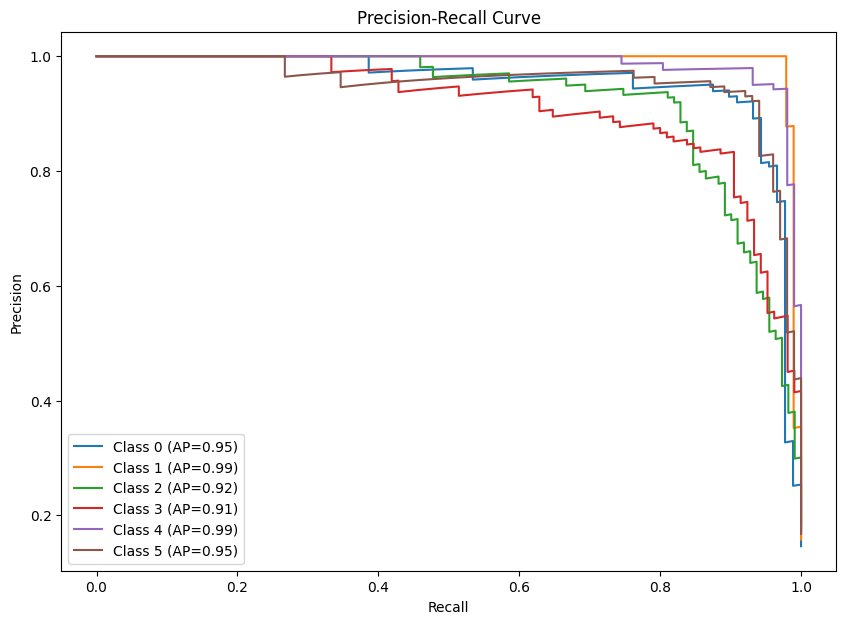


Training with 312 layers unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.7460 - loss: 0.7346 - val_accuracy: 0.8837 - val_loss: 0.2724
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - accuracy: 0.9545 - loss: 0.1361 - val_accuracy: 0.9070 - val_loss: 0.2653
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 435ms/step - accuracy: 0.9901 - loss: 0.0411 - val_accuracy: 0.9236 - val_loss: 0.2443
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9921 - loss: 0.0329 - val_accuracy: 0.8920 - val_loss: 0.4532
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 445ms/step - accuracy: 0.9834 - loss: 0.0478 - val_accuracy: 0.8638 - val_loss: 0.6012
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 437ms/step - accuracy: 0.9806 - loss: 0.0645 - val_accuracy: 0.8953 - val_loss: 0.4635
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 441ms/step - accuracy: 0.9853 - loss: 0.0431 - val_accuracy: 0.8987 - val_loss: 0.3754
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 441ms/step - accura

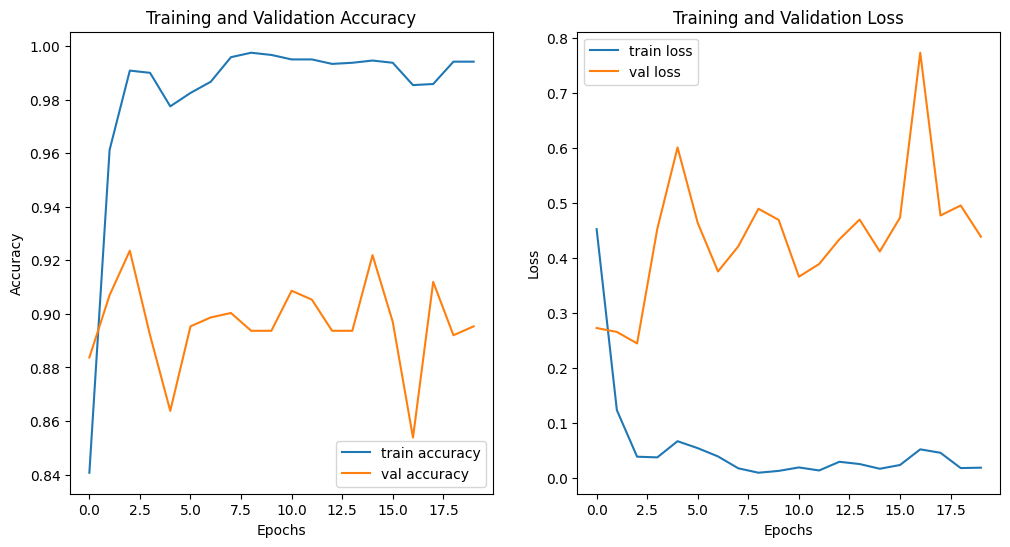

Confusion Matrix:
 [[76  0  0  0  0 12]
 [ 0 92  0  2  1  0]
 [ 0  0 92 17  2  0]
 [ 1  0  8 95  1  0]
 [ 1  0  2  9 90  0]
 [ 5  0  0  2  0 94]]


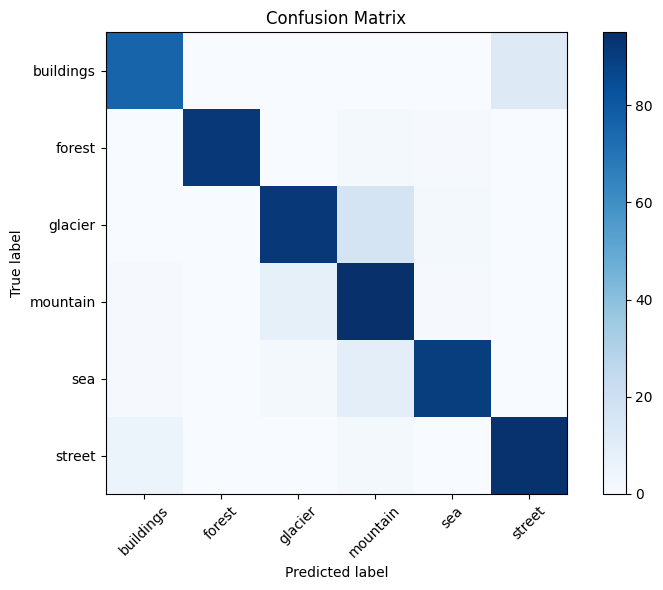

Classification Report:
               precision    recall  f1-score   support

   buildings       0.92      0.86      0.89        88
      forest       1.00      0.97      0.98        95
     glacier       0.90      0.83      0.86       111
    mountain       0.76      0.90      0.83       105
         sea       0.96      0.88      0.92       102
      street       0.89      0.93      0.91       101

    accuracy                           0.90       602
   macro avg       0.90      0.90      0.90       602
weighted avg       0.90      0.90      0.90       602



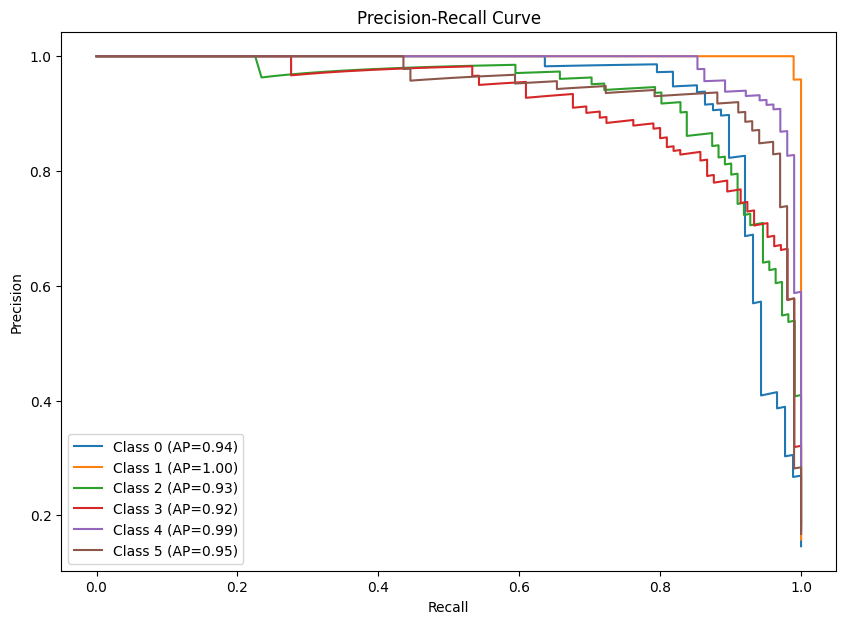

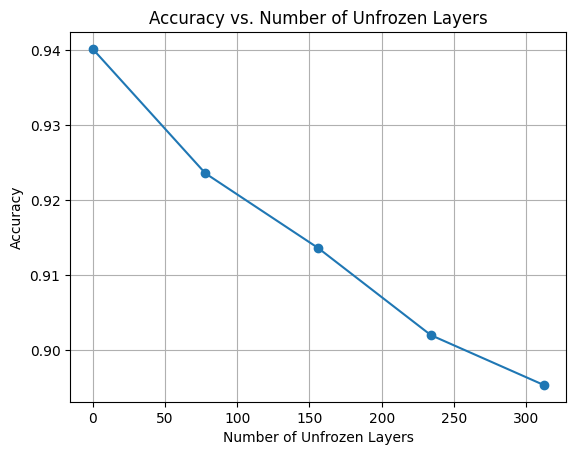

Experiment complete. Results: [(0, 0.9401993355481728), (78, 0.9235880398671097), (156, 0.9136212624584718), (234, 0.9019933554817275), (312, 0.8953488372093024)]


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Define the model using InceptionV3 with configurable unfreeze layers
def define_inception_model(num_classes, unfreeze_layers=0):
    # Load the pre-trained InceptionV3 model without the top classifier layer
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    
    # Freeze all layers by default
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the specified number of layers
    for i in range(len(base_model.layers) - unfreeze_layers, len(base_model.layers)):
        base_model.layers[i].trainable = True

    # Build the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_initializer='he_uniform'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Function to plot training & validation accuracy and loss curves
def plot_curves(history):
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

# Function to plot precision-recall curves
def plot_pr_curve(y_true, y_probs, num_classes):
    plt.figure(figsize=(10, 7))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        average_precision = average_precision_score(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f'Class {i} (AP={average_precision:.2f})')

    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.show()

# Train only the FC layer
def train_fc_layer(train_it, test_it, num_classes):
    print("\nTraining only the FC layer...")

    # Define the model with all layers frozen
    model = define_inception_model(num_classes, unfreeze_layers=0)

    # Train the model
    history = model.fit(train_it, validation_data=test_it, epochs=10, verbose=1)

    # Evaluate the model
    test_steps = len(test_it)
    y_probs = model.predict(test_it, steps=test_steps, verbose=1)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = test_it.classes

    # Compute metrics
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Accuracy with FC layer training only: {accuracy:.4f}")

    # Plot curves
    plot_curves(history)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    class_names = list(test_it.class_indices.keys())
    plot_confusion_matrix(cm, class_names)

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", report)

    return model

# Experiment function
def run_inception_experiment(train_dir, test_dir, num_classes, divisions):
    # Prepare data generators
    datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    train_it = datagen.flow_from_directory(train_dir, batch_size=32, target_size=(299, 299), class_mode='categorical', shuffle=True)
    test_it = datagen.flow_from_directory(test_dir, batch_size=32, target_size=(299, 299), class_mode='categorical', shuffle=False)

    total_layers = len(InceptionV3(weights='imagenet').layers)
    layers_per_division = total_layers // divisions

    results = []
    for i in range(divisions + 1):
        unfreeze_layers = i * layers_per_division
        print(f"\nTraining with {unfreeze_layers} layers unfrozen...")

        # Define and train the model
        model = define_inception_model(num_classes, unfreeze_layers)
        history = model.fit(train_it, validation_data=test_it, epochs=20, verbose=1)

        # Evaluate the model
        test_steps = len(test_it)
        y_probs = model.predict(test_it, steps=test_steps, verbose=1)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = test_it.classes

        # Compute metrics
        accuracy = np.sum(y_pred == y_true) / len(y_true)
        results.append((unfreeze_layers, accuracy))
        print(f"Accuracy with {unfreeze_layers} unfrozen layers: {accuracy:.4f}")

        # Plot curves
        plot_curves(history)

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)
        class_names = list(test_it.class_indices.keys())
        plot_confusion_matrix(cm, class_names)

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=class_names)
        print("Classification Report:\n", report)

        # Precision-Recall Curves
        y_true_one_hot = np.zeros((len(y_true), num_classes))
        y_true_one_hot[np.arange(len(y_true)), y_true] = 1
        plot_pr_curve(y_true_one_hot, y_probs, num_classes)

    # Plot overall results
    unfreeze_counts, accuracies = zip(*results)
    plt.plot(unfreeze_counts, accuracies, marker='o')
    plt.title("Accuracy vs. Number of Unfrozen Layers")
    plt.xlabel("Number of Unfrozen Layers")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.show()

    return results

# Main function to execute the two-step experiment
if __name__ == "__main__":
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'
    num_classes = 6  # Update based on the dataset
    divisions = 4    # Number of divisions for unfreezing layers

    # Prepare data generators
    datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    train_it = datagen.flow_from_directory(train_dir, batch_size=32, target_size=(299, 299), class_mode='categorical', shuffle=True)
    test_it = datagen.flow_from_directory(test_dir, batch_size=32, target_size=(299, 299), class_mode='categorical', shuffle=False)

    # Step 1: Train only the FC layer
    model_fc_trained = train_fc_layer(train_it, test_it, num_classes)

    # Step 2: Gradually unfreeze layers and train
    print("\nProceeding to the main experiment with gradual unfreezing of layers...")
    results = run_inception_experiment(train_dir, test_dir, num_classes, divisions)
    print("Experiment complete. Results:", results)


Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.

Training only the FC layer...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 300ms/step - accuracy: 0.1684 - loss: 1.7935 - val_accuracy: 0.1744 - val_loss: 1.7893
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.1775 - loss: 1.7909 - val_accuracy: 0.1844 - val_loss: 1.7891
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1743 - loss: 1.7909 - val_accuracy: 0.1844 - val_loss: 1.7888
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.1877 - loss: 1.7893 - val_accuracy: 0.1844 - val_loss: 1.7888
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.1748 - loss: 1.7908 - val_accuracy: 0.1844 - val_loss: 1.7889
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.1595 - loss: 1.7922 - val_accuracy: 0.1844 - val_loss: 1.7888
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.1780 - loss: 1.7888 - val_accuracy: 0.1844 - val_loss: 1.

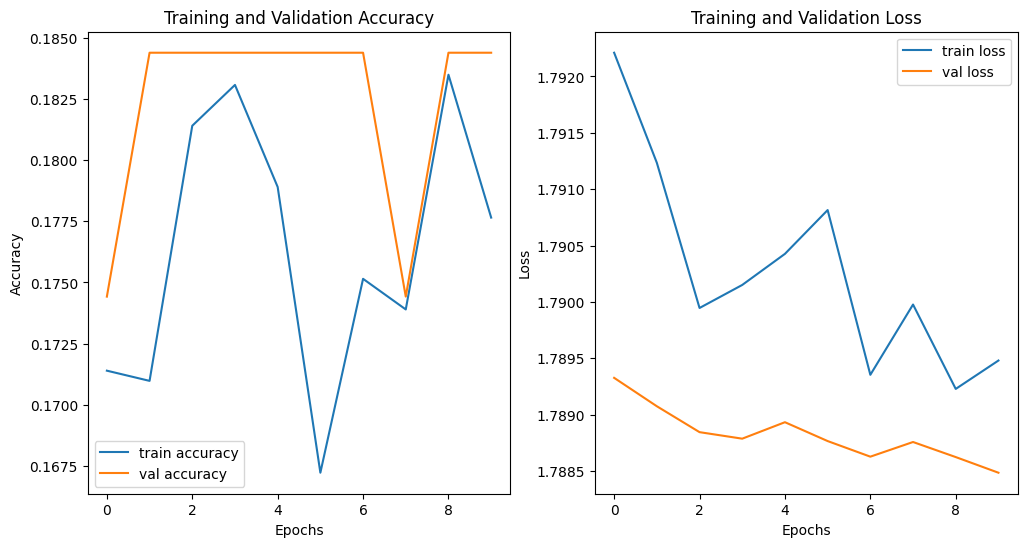

Confusion Matrix:
 [[  0   0  88   0   0   0]
 [  0   0  95   0   0   0]
 [  0   0 111   0   0   0]
 [  0   0 105   0   0   0]
 [  0   0 102   0   0   0]
 [  0   0 101   0   0   0]]


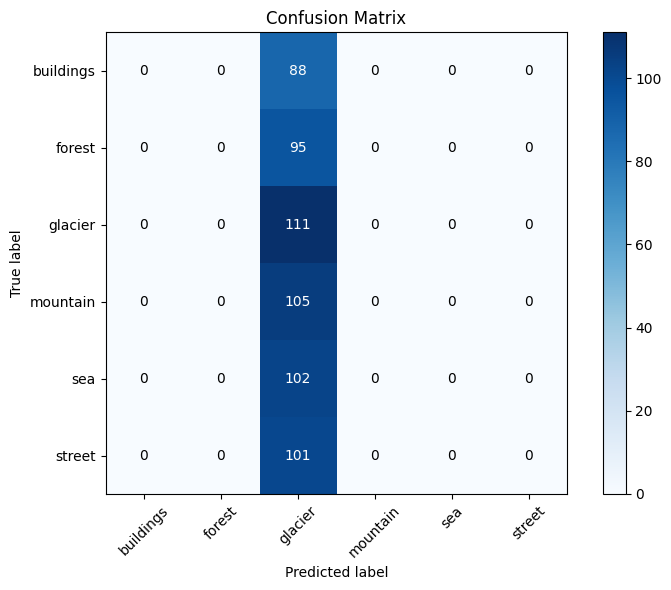

Classification Report:
               precision    recall  f1-score   support

   buildings       0.00      0.00      0.00        88
      forest       0.00      0.00      0.00        95
     glacier       0.18      1.00      0.31       111
    mountain       0.00      0.00      0.00       105
         sea       0.00      0.00      0.00       102
      street       0.00      0.00      0.00       101

    accuracy                           0.18       602
   macro avg       0.03      0.17      0.05       602
weighted avg       0.03      0.18      0.06       602


Proceeding to the main experiment with gradual unfreezing of layers...
Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training with 0 layers unfrozen...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 247ms/step - accuracy: 0.1589 - loss: 1.7905 - val_accuracy: 0.1844 - val_loss: 1.7891
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1764 - loss: 1.7916 - val_accuracy: 0.1844 - val_loss: 1.7891
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.1833 - loss: 1.7898 - val_accuracy: 0.1844 - val_loss: 1.7889
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1905 - loss: 1.7886 - val_accuracy: 0.1844 - val_loss: 1.7888
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1890 - loss: 1.7893 - val_accuracy: 0.1844 - val_loss: 1.7888
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.1882 - loss: 1.7886 - val_accuracy: 0.1844 - val_loss: 1.7887
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1903 - loss: 1.7904 - val_accuracy: 0.1844 - val_loss: 1.7888
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.1850 - loss: 1.7882 - val_accuracy: 0.1844 - val_loss: 

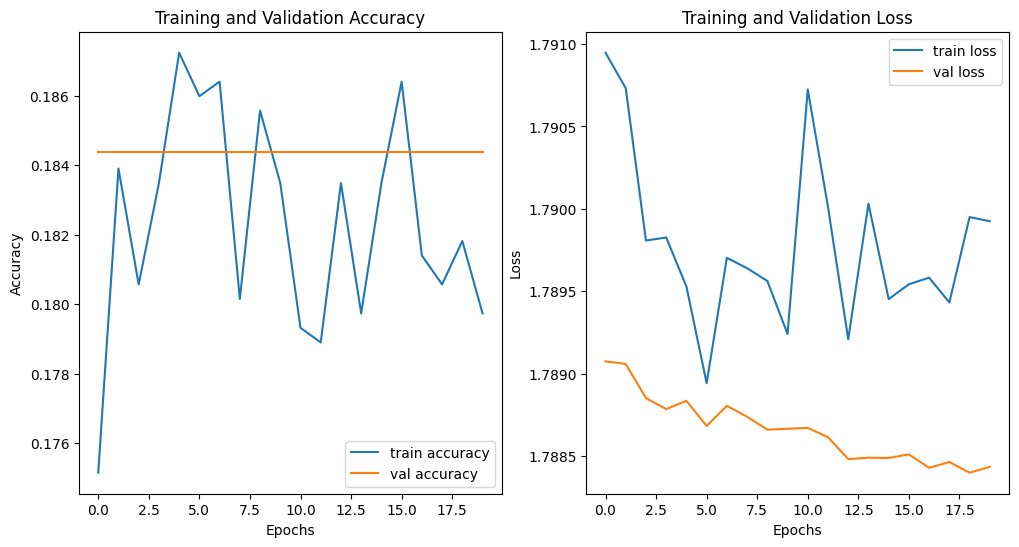

Confusion Matrix:
 [[  0   0  88   0   0   0]
 [  0   0  95   0   0   0]
 [  0   0 111   0   0   0]
 [  0   0 105   0   0   0]
 [  0   0 102   0   0   0]
 [  0   0 101   0   0   0]]


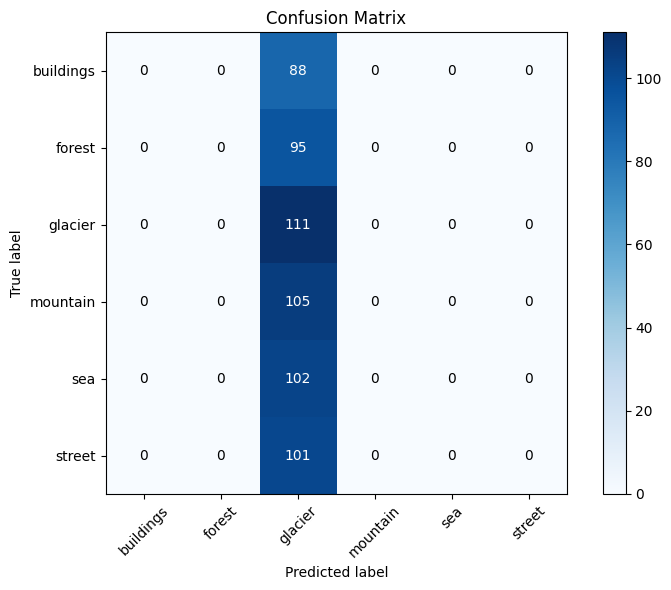

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

   buildings       0.00      0.00      0.00        88
      forest       0.00      0.00      0.00        95
     glacier       0.18      1.00      0.31       111
    mountain       0.00      0.00      0.00       105
         sea       0.00      0.00      0.00       102
      street       0.00      0.00      0.00       101

    accuracy                           0.18       602
   macro avg       0.03      0.17      0.05       602
weighted avg       0.03      0.18      0.06       602



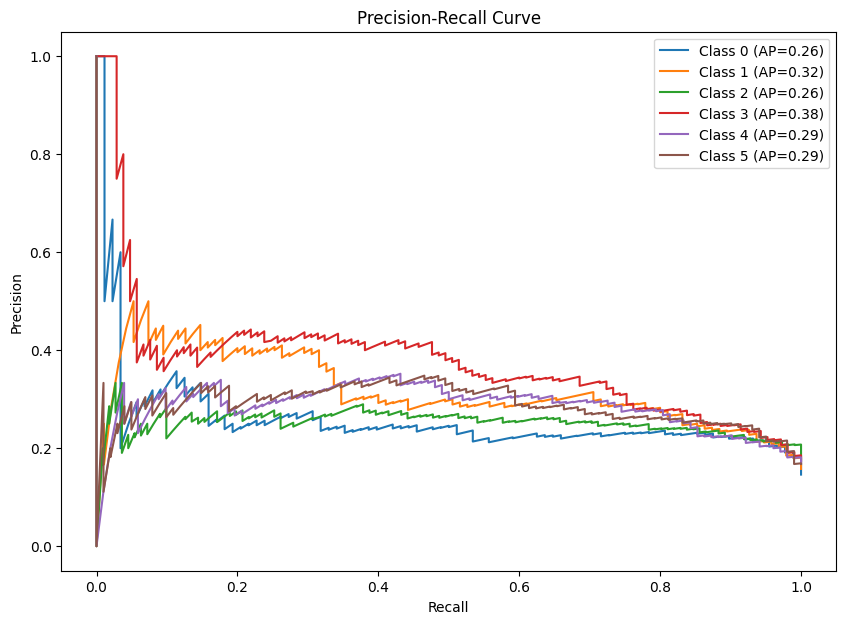


Training with 60 layers unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 359ms/step - accuracy: 0.1831 - loss: 1.8185 - val_accuracy: 0.1844 - val_loss: 1.7994
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.1967 - loss: 1.7847 - val_accuracy: 0.1844 - val_loss: 1.7928
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.2113 - loss: 1.7508 - val_accuracy: 0.1844 - val_loss: 1.7932
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.2059 - loss: 1.7151 - val_accuracy: 0.1578 - val_loss: 1.8006
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.2249 - loss: 1.7243 - val_accuracy: 0.1578 - val_loss: 1.8929
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.2503 - loss: 1.6841 - val_accuracy: 0.1578 - val_loss: 2.1574
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.2598 - loss: 1.6611 - val_accuracy: 0.2043 - val_loss: 2.2759
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.2562 - 

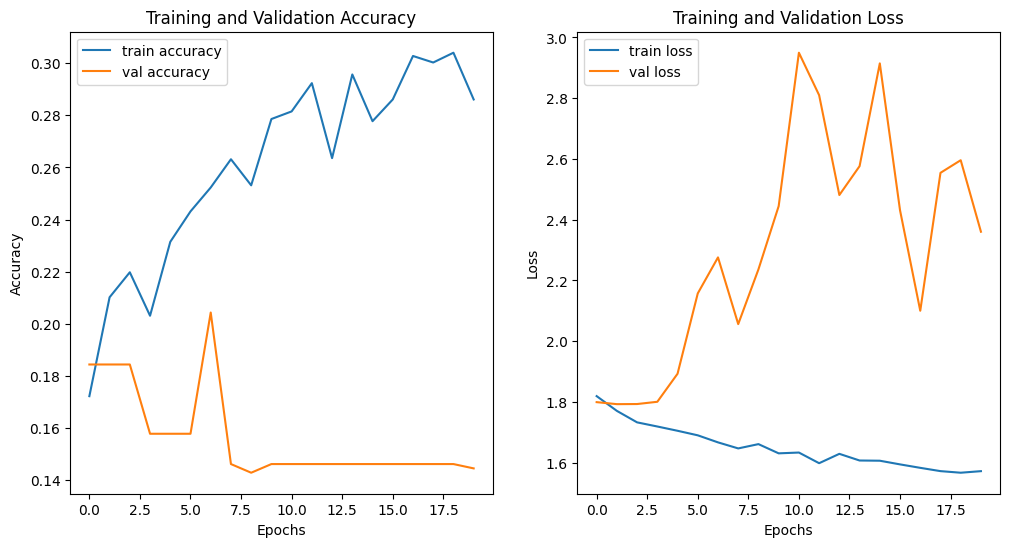

Confusion Matrix:
 [[ 86   2   0   0   0   0]
 [ 94   1   0   0   0   0]
 [111   0   0   0   0   0]
 [105   0   0   0   0   0]
 [102   0   0   0   0   0]
 [101   0   0   0   0   0]]


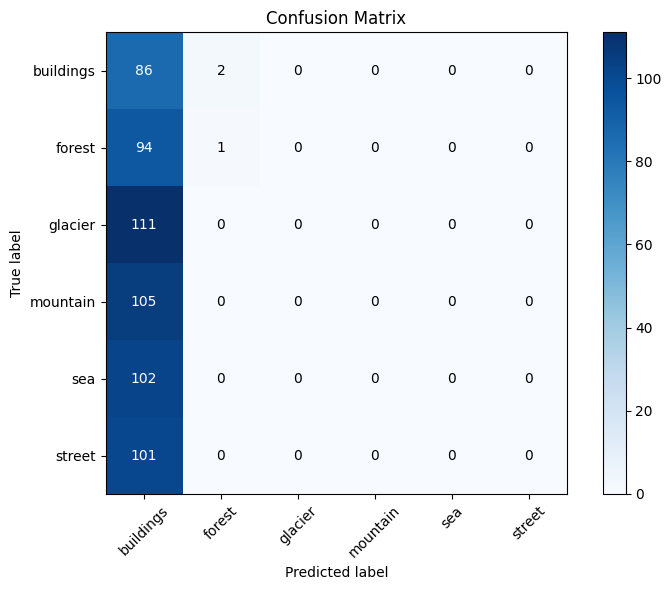

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

   buildings       0.14      0.98      0.25        88
      forest       0.33      0.01      0.02        95
     glacier       0.00      0.00      0.00       111
    mountain       0.00      0.00      0.00       105
         sea       0.00      0.00      0.00       102
      street       0.00      0.00      0.00       101

    accuracy                           0.14       602
   macro avg       0.08      0.16      0.05       602
weighted avg       0.07      0.14      0.04       602



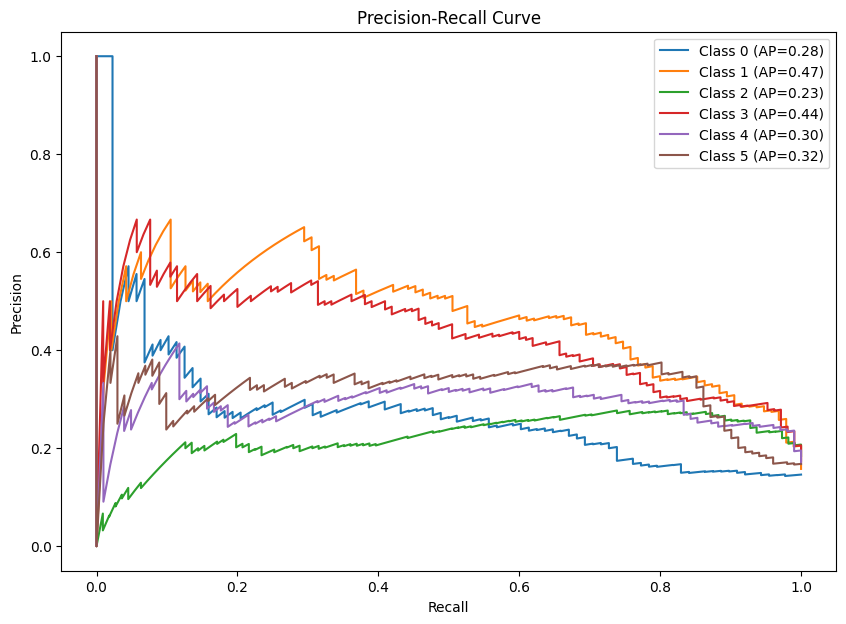


Training with 120 layers unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 480ms/step - accuracy: 0.2510 - loss: 1.6864 - val_accuracy: 0.1578 - val_loss: 1.8133
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.3862 - loss: 1.4147 - val_accuracy: 0.1927 - val_loss: 1.8030
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.4452 - loss: 1.2933 - val_accuracy: 0.1844 - val_loss: 1.8251
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5023 - loss: 1.1912 - val_accuracy: 0.1595 - val_loss: 2.0398
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5463 - loss: 1.1082 - val_accuracy: 0.1661 - val_loss: 2.1621
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5742 - loss: 1.0772 - val_accuracy: 0.1694 - val_loss: 2.4265
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.6006 - loss: 0.9997 - val_accuracy: 0.1977 - val_loss: 2.8964
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5739 -

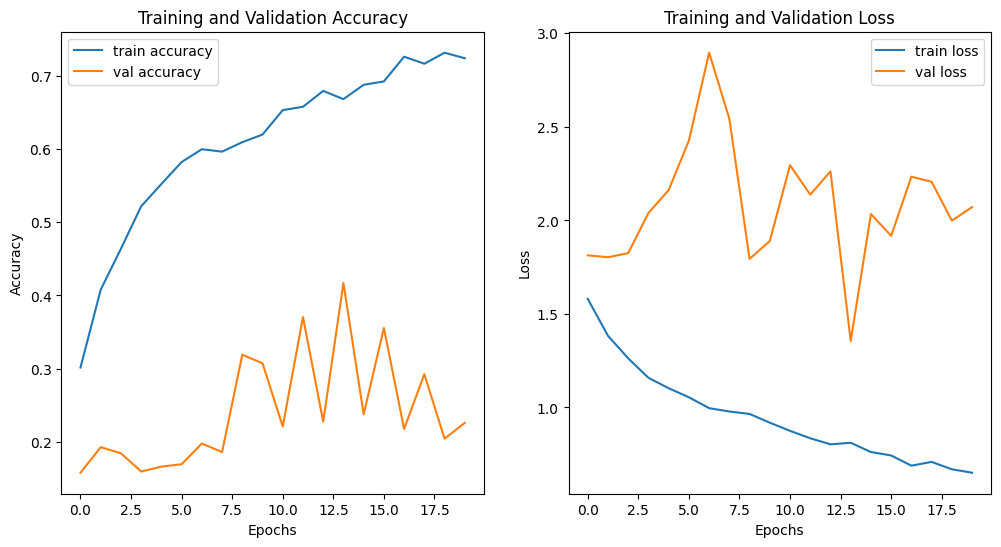

Confusion Matrix:
 [[21  0 64  3  0  0]
 [23  0 70  1  0  1]
 [ 0  0 90 21  0  0]
 [ 0  0 80 25  0  0]
 [ 2  0 68 32  0  0]
 [22  0 77  2  0  0]]


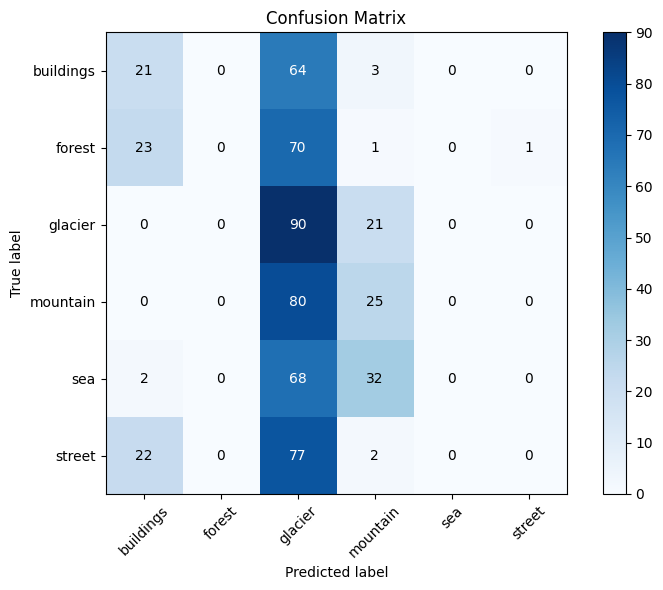

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

   buildings       0.31      0.24      0.27        88
      forest       0.00      0.00      0.00        95
     glacier       0.20      0.81      0.32       111
    mountain       0.30      0.24      0.26       105
         sea       0.00      0.00      0.00       102
      street       0.00      0.00      0.00       101

    accuracy                           0.23       602
   macro avg       0.13      0.21      0.14       602
weighted avg       0.13      0.23      0.14       602



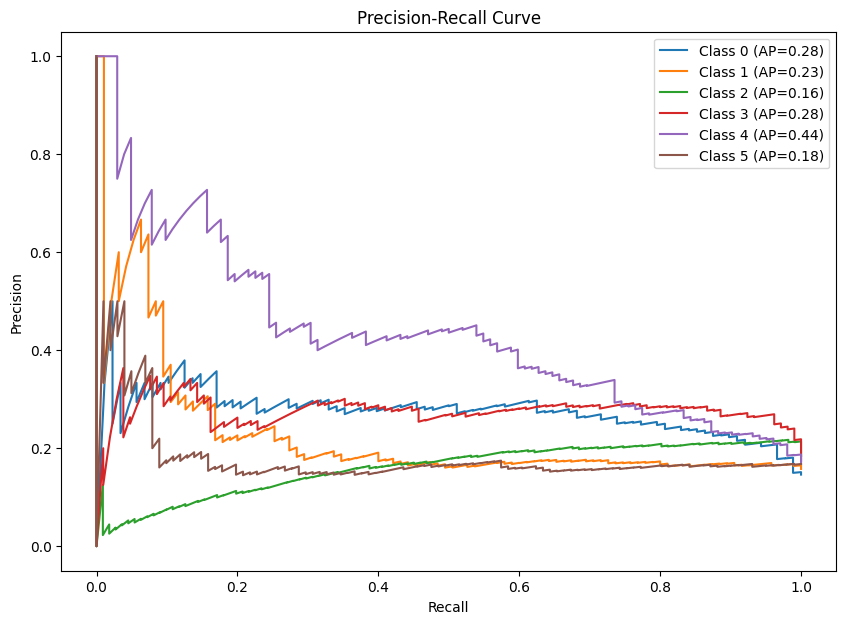


Training with 180 layers unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 96s 572ms/step - accuracy: 0.3761 - loss: 1.5025 - val_accuracy: 0.1744 - val_loss: 1.8040
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6229 - loss: 0.9761 - val_accuracy: 0.1578 - val_loss: 1.8299
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6837 - loss: 0.8556 - val_accuracy: 0.1578 - val_loss: 1.8765
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.7411 - loss: 0.7112 - val_accuracy: 0.1578 - val_loss: 1.8893
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.7843 - loss: 0.5976 - val_accuracy: 0.1578 - val_loss: 1.8250
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8078 - loss: 0.5151 - val_accuracy: 0.1728 - val_loss: 1.8270
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.8166 - loss: 0.4707 - val_accuracy: 0.2874 - val_loss: 1.7558
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8481 -

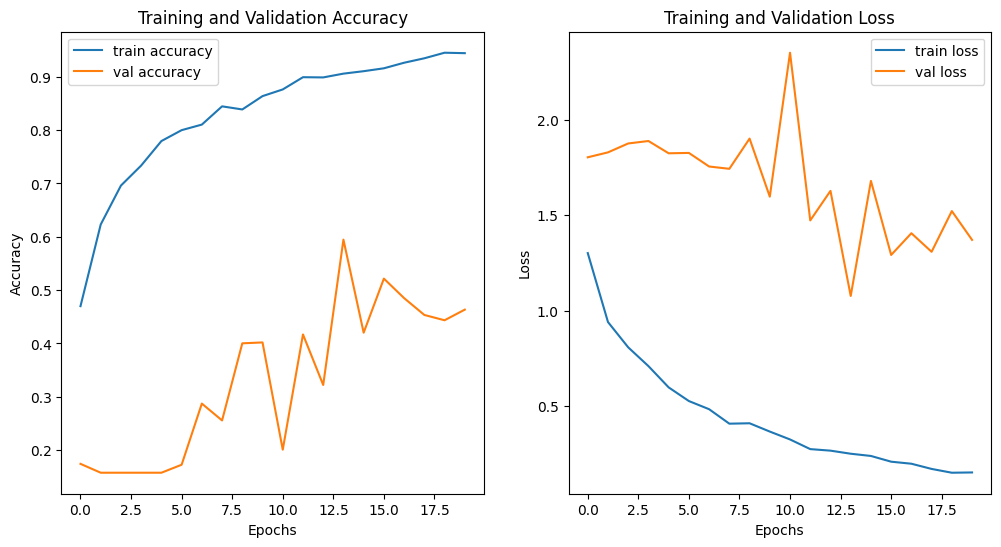

Confusion Matrix:
 [[44 11  0  0 16 17]
 [ 4 77  0  0 11  3]
 [ 8  4  7  3 89  0]
 [ 2  1  0  3 99  0]
 [ 5  6  1  2 87  1]
 [17 11  0  0 12 61]]


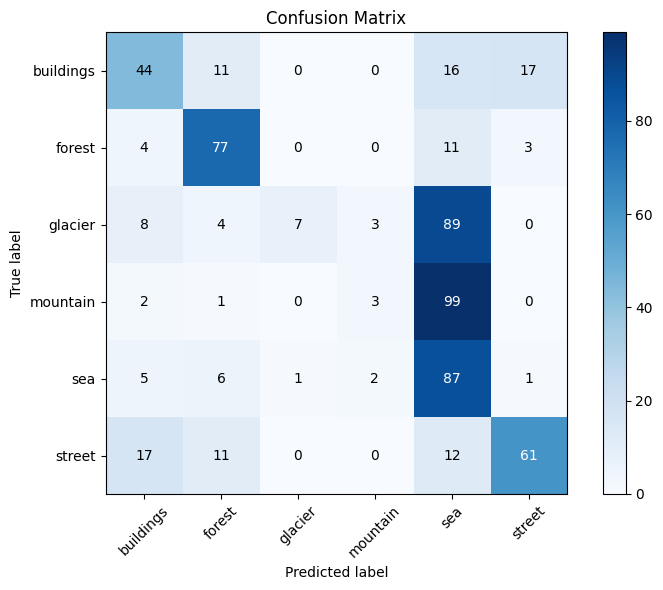

Classification Report:
               precision    recall  f1-score   support

   buildings       0.55      0.50      0.52        88
      forest       0.70      0.81      0.75        95
     glacier       0.88      0.06      0.12       111
    mountain       0.38      0.03      0.05       105
         sea       0.28      0.85      0.42       102
      street       0.74      0.60      0.67       101

    accuracy                           0.46       602
   macro avg       0.59      0.48      0.42       602
weighted avg       0.59      0.46      0.41       602



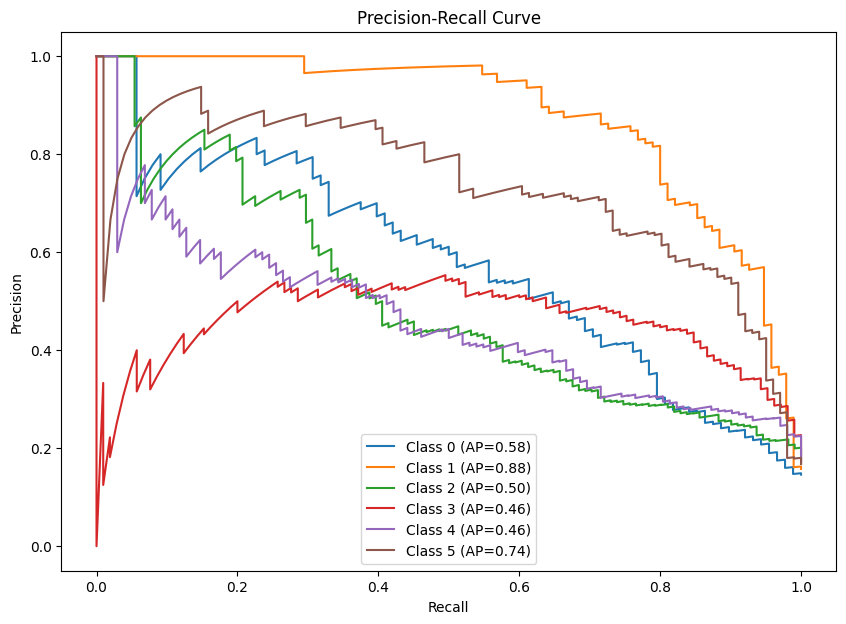


Training with 240 layers unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 120s 759ms/step - accuracy: 0.5458 - loss: 1.3181 - val_accuracy: 0.1744 - val_loss: 1.7922
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.8896 - loss: 0.3312 - val_accuracy: 0.1744 - val_loss: 1.7967
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.9527 - loss: 0.1603 - val_accuracy: 0.2027 - val_loss: 1.7692
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9661 - loss: 0.1239 - val_accuracy: 0.1860 - val_loss: 1.7780
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9782 - loss: 0.0869 - val_accuracy: 0.3023 - val_loss: 1.6509
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9889 - loss: 0.0485 - val_accuracy: 0.4850 - val_loss: 1.3629
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.9939 - loss: 0.0410 - val_accuracy: 0.6146 - val_loss: 1.0299
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - acc

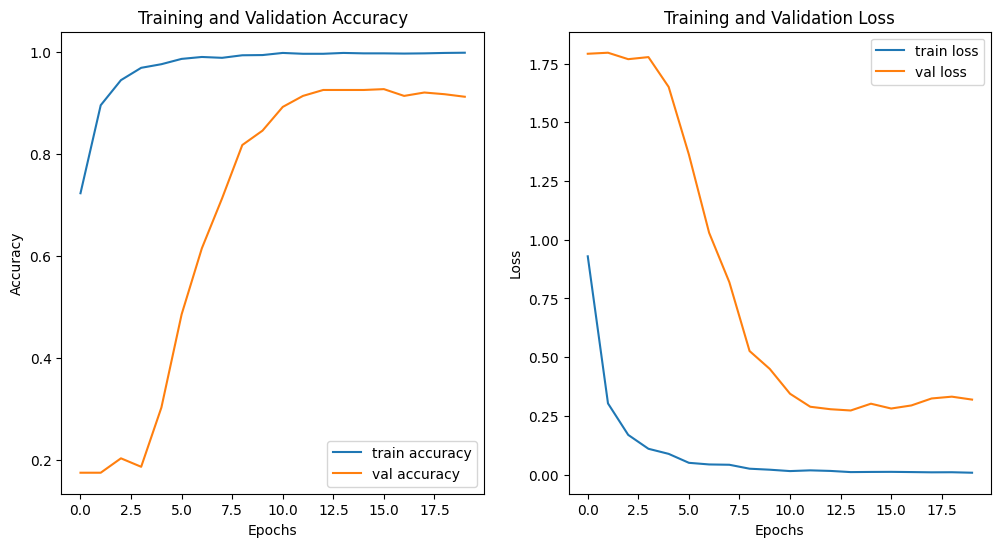

Confusion Matrix:
 [[80  0  0  0  0  8]
 [ 0 94  0  1  0  0]
 [ 0  0 93 15  3  0]
 [ 0  1 11 91  2  0]
 [ 1  0  1  1 99  0]
 [ 7  0  0  1  1 92]]


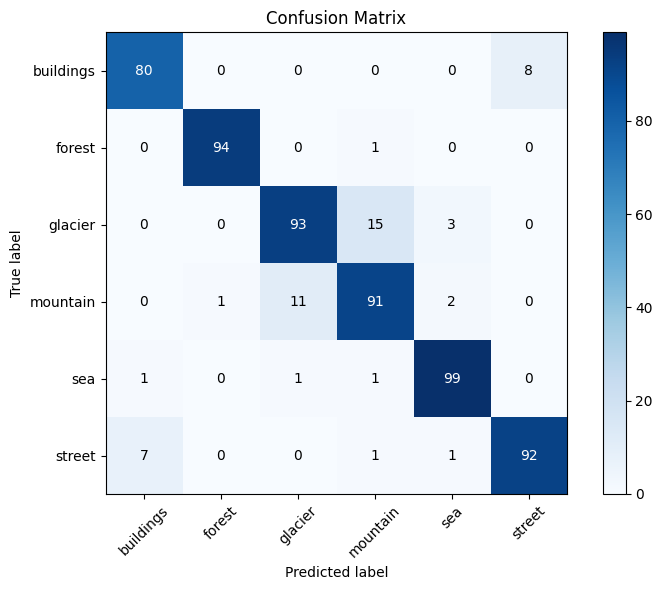

Classification Report:
               precision    recall  f1-score   support

   buildings       0.91      0.91      0.91        88
      forest       0.99      0.99      0.99        95
     glacier       0.89      0.84      0.86       111
    mountain       0.83      0.87      0.85       105
         sea       0.94      0.97      0.96       102
      street       0.92      0.91      0.92       101

    accuracy                           0.91       602
   macro avg       0.91      0.91      0.91       602
weighted avg       0.91      0.91      0.91       602



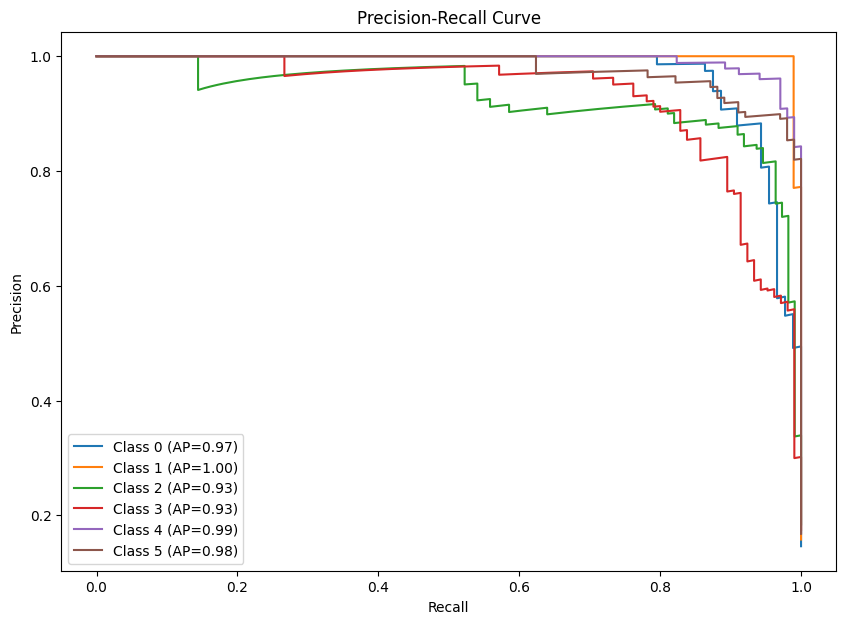

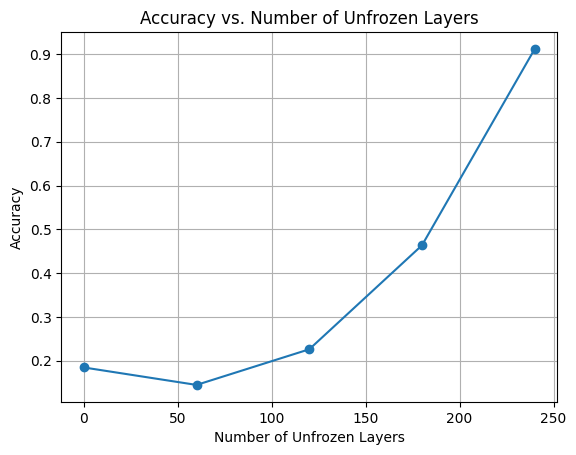

Experiment complete. Results: [(0, 0.18438538205980065), (60, 0.14451827242524917), (120, 0.22591362126245848), (180, 0.4634551495016611), (240, 0.9119601328903655)]


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Define the model using EfficientNetB0 with configurable unfreeze layers
def define_efficientnet_model(num_classes, unfreeze_layers=0):
    # Load the pre-trained EfficientNetB0 model without the top classifier layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze all layers by default
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the specified number of layers
    for i in range(len(base_model.layers) - unfreeze_layers, len(base_model.layers)):
        base_model.layers[i].trainable = True

    # Build the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_initializer='he_uniform'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Function to plot training & validation accuracy and loss curves
def plot_curves(history):
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Function to plot the confusion matrix with values inside the boxes
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

    # Display values in each box
    thresh = cm.max() / 2.0  # Threshold for coloring the text
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.show()

# Function to plot precision-recall curves
def plot_pr_curve(y_true, y_probs, num_classes):
    plt.figure(figsize=(10, 7))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        average_precision = average_precision_score(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f'Class {i} (AP={average_precision:.2f})')

    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.show()

# Train only the FC layer
def train_fc_layer(train_it, test_it, num_classes):
    print("\nTraining only the FC layer...")

    # Define the model with all layers frozen
    model = define_efficientnet_model(num_classes, unfreeze_layers=0)

    # Train the model
    history = model.fit(train_it, validation_data=test_it, epochs=10, verbose=1)

    # Evaluate the model
    test_steps = len(test_it)
    y_probs = model.predict(test_it, steps=test_steps, verbose=1)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = test_it.classes

    # Compute metrics
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Accuracy with FC layer training only: {accuracy:.4f}")

    # Plot curves
    plot_curves(history)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    class_names = list(test_it.class_indices.keys())
    plot_confusion_matrix(cm, class_names)

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", report)

    return model

# Experiment function
def run_efficientnet_experiment(train_dir, test_dir, num_classes, divisions):
    # Prepare data generators
    datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    train_it = datagen.flow_from_directory(train_dir, batch_size=32, target_size=(224, 224), class_mode='categorical', shuffle=True)
    test_it = datagen.flow_from_directory(test_dir, batch_size=32, target_size=(224, 224), class_mode='categorical', shuffle=False)

    total_layers = len(EfficientNetB0(weights='imagenet').layers)
    layers_per_division = total_layers // divisions

    results = []
    for i in range(divisions + 1):
        unfreeze_layers = i * layers_per_division
        print(f"\nTraining with {unfreeze_layers} layers unfrozen...")

        # Define and train the model
        model = define_efficientnet_model(num_classes, unfreeze_layers)
        history = model.fit(train_it, validation_data=test_it, epochs=20, verbose=1)

        # Evaluate the model
        test_steps = len(test_it)
        y_probs = model.predict(test_it, steps=test_steps, verbose=1)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = test_it.classes

        # Compute metrics
        accuracy = np.sum(y_pred == y_true) / len(y_true)
        results.append((unfreeze_layers, accuracy))
        print(f"Accuracy with {unfreeze_layers} unfrozen layers: {accuracy:.4f}")

        # Plot curves
        plot_curves(history)

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)
        class_names = list(test_it.class_indices.keys())
        plot_confusion_matrix(cm, class_names)

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=class_names)
        print("Classification Report:\n", report)

        # Precision-Recall Curves
        y_true_one_hot = np.zeros((len(y_true), num_classes))
        y_true_one_hot[np.arange(len(y_true)), y_true] = 1
        plot_pr_curve(y_true_one_hot, y_probs, num_classes)

    # Plot overall results
    unfreeze_counts, accuracies = zip(*results)
    plt.plot(unfreeze_counts, accuracies, marker='o')
    plt.title("Accuracy vs. Number of Unfrozen Layers")
    plt.xlabel("Number of Unfrozen Layers")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.show()

    return results

# Main function to execute the two-step experiment
if __name__ == "__main__":
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'
    num_classes = 6  # Update based on the dataset
    divisions = 4    # Number of divisions for unfreezing layers

    # Prepare data generators
    datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    train_it = datagen.flow_from_directory(train_dir, batch_size=32, target_size=(224, 224), class_mode='categorical', shuffle=True)
    test_it = datagen.flow_from_directory(test_dir, batch_size=32, target_size=(224, 224), class_mode='categorical', shuffle=False)

    # Step 1: Train only the FC layer
    model_fc_trained = train_fc_layer(train_it, test_it, num_classes)

    # Step 2: Gradually unfreeze layers and train
    print("\nProceeding to the main experiment with gradual unfreezing of layers...")
    results = run_efficientnet_experiment(train_dir, test_dir, num_classes, divisions)
    print("Experiment complete. Results:", results)
